#Survival Analysis with Python

This notebook demonstrates the basics of survival analysis, a method used for analyzing time to event data, using Python. It has 6 sections. 

1) A brief introduction to survival analysis and the data used in this notebook

2) Non-parametric methods: Kaplan-meier curves, Log-rank test statistic for $\geq2$ groups

3) Semi-parametric methods: Cox proportional hazard model, Schoenfeld residuals, log-log plots

4) Parametric methods: Exponential (accelerated failure time (AFT), proportional hazards (PH)), Weibull (AFT, PH), Gompertz (PH), Log-logistic (proportional odds (PO)), Log-normal (AFT), Generalized Gamma (AFT) 

5) Constructing confidence intervals for survival predictions for the models in section 4

6) Appendix A: Parametric Model Results with Different Optimization Methods

##1) A brief introduction to survival analysis and the data used in this notebook

Survival analysis aims to model time to event data. A key part of survival analysis is the modeling of the contribution of censored observations to the likelihood of model parameters. Censored observations are those for which we have not observed the event (also called right-censoring). The event could be the death of a patient, diagnosis of a disease, failure of a machine part and in this analysis, it is defined as the end of terrorist groups. In the dataset that we will use, not all terrorist groups ended until the end of the observation period. Survival analysis is a suitable method to analyze the factors that influence the time to end of these groups. One very important assumption of survival analysis is that the time to event for censored terror groups does not systematically differ from those whose end we have observed. 

If time to event has the probability density function $f(t)$ and cumulative distribution function $F(t)$, then the probability of surviving at least to time $t$ is: $Pr(T>t)=S(t)=1-F(t)$. Cumulative hazard at time $t$ is defined as $H(t)=-ln(S(t))$ and instantaneous hazard at time $t$ is $h(t)=\frac{dH(t)}{dt}$. The instantateous hazard can also be written as $h(t)=\frac{f(t)}{S(t)}$

The likelihood function for survival analysis is described as:

$$ l(\beta) = \prod\limits_{i=1}^n h(t_i)^{d_i} S(t_i) $$

where $d_i$ is the censoring variable that equals to 1 if the event is observed for individual $i$ and 0 if the event is not observed (censored) for individual $i$, $h(t_i)$ is the hazard for individual $i$ at time $t$, $H(t_i)$ is the cumulative hazard for individual $i$ at time $t$, and $S(t_i)$ is the survival probability for individual $i$ at time $t$. Note that when $d_i=0$, the contribution of the $i$'th individual to the likelihood function is just its survival probability until time $t$: S(t). If the individual has the event, the contribution to the likelihood function is given by the density function $f(t)=h(t)S(t)$.

The log of likelihood is:

$$ logl(\beta) = \sum\limits_{i=1}^n d_i log(h(t_i)) - H(t_i) $$

where $log$ is the natural logarithm.

The dataset used here is from Jones and Libicki 'How Terrorist Groups End' (Santa Monica, 2008, RAND Corporation). The full report can be found here:

http://www.rand.org/content/dam/rand/pubs/monographs/2008/RAND_MG741-1.pdf

Jones and Libicki use data from RAND - Oklahoma City National Memorial Institute for the Prevention of Terrorism (MIPT) Terrorism Incident database to investigate the factors that contribute to end of terrorist groups. The data includes starting time for 648 terrorist groups that operated between 1968 and 2006. For each of the 648 terrorist groups, there are 5 categorical variables. 

Operating Peak Size: The peak size of the group. The variable can take the followng values; 10,000s (10,000 or more), 1,000s (1,000-9,999), 100s (100-999) and 10s (less than 100).

Econ: The income level of the base country, described according to World Bank criteria in the year in which the group ended or in 2006 if the group has not ended. The variable can take one of four values; 
H = high income (\$10,726 or more, in 2005 gross national income [GNI] per capita, calculated using the World Bank Atlas Method) 
UM = upper middle income (\$3,466–\$10,725)
LM = lower middle income (\$876–\$3,465)
L = low income (\$875 or less)

'Goal' is the primary goal of the terrorist group. It can be one of 'Regime_change','Territorial_change','Policy_change','Empire','Social_revolution','Status_Quo'

'Regime' is the level of freedom in the country against which the terrorist group operates, according to Freedom House classification, based on an assessment of political rights and civil liberties. 'Regime' takes 'Not free', 'Partly free' and 'Free' values.

'Type' is the type of the terrorist group and it takes the following values 'Left_wing','Right_wing','Nationalist', 

'Reason' is the reason for ending, it can take the values 'Policing' 'Splintering' 'Politics' 'Victory' 'Military_force' and 'Not ended'

In addition to the variables described above, we need a 'time' and 'censored' variable to perform the survival analysis. 'Time' variable is the time in years since the start of the terrorist group's activities, either to the time when the terror group ended or to the last observation year (2006) if the terror group did not end until the end of the observed period (1968 - 2006). The censoring variable is labeled 'Ended' and it equals to 1 if the terror group ended between 1968 and 2006 and it equals to 0 if the terror group did not end until 2006.



Before starting the analyses, we need to import the following packages.

In [110]:
#We will use Pandas Dataframe object to hold our data
#and to perform necessary manipulations to prepare the dataset
#for analysis 
import pandas as pd
#%matplotlib inline
%matplotlib inline
#Iport matplotlib.pyplot for plotting results
import matplotlib.pyplot as plt
#Numpy will be used to perform numerical operations on arrays
#(calculate dot products, sums, exponentials, logarithms, find unique values)  
import numpy as np
#We will use scipy to calculate normal 
#distribution values
from scipy.stats import norm
#To set the working directory
import os as osvariable
#To read in csv file
from pandas import read_csv
#Lifelines is a survival analysis package. We will
#use its KaplanMeier curve plotting function,
#logrank_test and Cox proportional hazards fitter
#http://lifelines.readthedocs.org/en/latest/
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
#Import the statsmodels. We will use this to 
#fit linear functions to data, which will be 
#helpful to visually assess parametric fits
#http://statsmodels.sourceforge.net/
import statsmodels.api as st
#Genericlikelihood model is what we will use 
#to specify log-likelihood functions for survival
#models: Exponential (accelerated failure time (AFT), proportional hazards (PH)), 
#Weibull (AFT, PH), Gompertz (PH), Log-logistic (proportional odds (PO)), 
#Log-normal (AFT), Generalized Gamma (AFT) 
from statsmodels.base.model import GenericLikelihoodModel
#Import the functions that will be used to calculate the 
#generalized gamma function survival and its confidence
#intervals
#Gamma function
#http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.gamma.html
from scipy.special import gamma as gammafunction
#Lower regularized incomplete gamma function
#http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.gammainc.html
from scipy.special import gammainc
#Digamma function, which is used when taking the 
#derivative of the gamma function
from scipy.special import psi
#From mpmath library, we will use the meijer G function
#which is part of the derivative of the incomplete gamma function
#http://mpmath.googlecode.com/svn-history/r1229/trunk/doc/build/functions/hypergeometric.html
import mpmath
#from sympy library, we will use the DiracDelta function
#which is part of the derivative of the sign function which in turn
#is part of the generalized gamma function
#http://docs.sympy.org/dev/modules/functions/special.html
from sympy import DiracDelta

Next, set the working directory, load the dataset and prepare the dataset for analysis.

In [111]:
#set working directory:
osvariable.chdir('C:/Users/Mustafa/Desktop/matematik/Python/python_data/Terror_Data')
#Read in data
terrordata = read_csv('terrordata1.csv')
#Take a look at the dataset contents, print the first 5 observations
print(terrordata.head())
#Check the categorical variable values
print('Categorical variable values:')
print('Type values:',np.unique(terrordata['Type']))
print('Operating Peak Size values:',np.unique(terrordata['Operating Peak Size']))
print('Regime values:',np.unique(terrordata['Regime']))
print('Goal values:',np.unique(terrordata['Goal']))

   Time  Ended Operating Peak Size Econ. Regime Type Goal    Reason
0     3      0                 10s    LM     NF    R   RC  NotEnded
1     9      1                100s    UM     PF   LW   RC        PO
2    29      0                 10s    LM      F    N   TC         S
3     6      1                 10s     H      F   LW   PC         S
4     7      0                 10s    LM      F    R   PC         S
Categorical variable values:
('Type values:', array(['LW', 'N', 'R', 'RW', 'Reigious'], dtype=object))
('Operating Peak Size values:', array(['1,000s', '1,00s', '10,000s', '100s', '10S', '10c', '10s'], dtype=object))
('Regime values:', array(['BF', 'F', 'NF', 'PF'], dtype=object))
('Goal values:', array(['E', 'PC', 'RC', 'SQ', 'SR', 'TC', 'TCs'], dtype=object))


In [112]:
#One of the entries for 'Type' is entered as 'Reigious'. This
#should be coded as 'R'
terrordata.loc[(terrordata['Type'] == 'Reigious'),['Type']] = 'R'
#Correct the 'Operating Peak Size' variables that are 
#entered incorrectly
terrordata.loc[(terrordata['Operating Peak Size'] == '10S'),['Operating Peak Size']] = '10s'
terrordata.loc[(terrordata['Operating Peak Size'] == '10c'),['Operating Peak Size']] = '10s'
terrordata.loc[(terrordata['Operating Peak Size'] == '1,00s'),['Operating Peak Size']] = '1,000s'
#One of the entries for 'Regime' is entered incorrectly as 'BF'
terrordata.loc[(terrordata['Regime'] == 'BF'),['Regime']] = 'NF'
#One of the entries for 'Goal' is entered incorrectly as 'TCs'
terrordata.loc[(terrordata['Goal'] == 'TCs'),['Goal']] = 'TC'
#Check the categorical variable values again
print(np.unique(terrordata['Type']))
print(np.unique(terrordata['Operating Peak Size']))
print(np.unique(terrordata['Regime']))
print(np.unique(terrordata['Goal']))

['LW' 'N' 'R' 'RW']
['1,000s' '10,000s' '100s' '10s']
['F' 'NF' 'PF']
['E' 'PC' 'RC' 'SQ' 'SR' 'TC']


In [113]:
#Take a look at the unique values for categorical variables
#Check the categorical variable values
print('Categorical variable values:')
print('Type values:',np.unique(terrordata['Type']))
print('Operating Peak Size values:',np.unique(terrordata['Operating Peak Size']))
print('Regime values:',np.unique(terrordata['Regime']))
print('Goal values:',np.unique(terrordata['Goal']))

Categorical variable values:
('Type values:', array(['LW', 'N', 'R', 'RW'], dtype=object))
('Operating Peak Size values:', array(['1,000s', '10,000s', '100s', '10s'], dtype=object))
('Regime values:', array(['F', 'NF', 'PF'], dtype=object))
('Goal values:', array(['E', 'PC', 'RC', 'SQ', 'SR', 'TC'], dtype=object))


In [114]:
#Replace abbreviations with words to make reading tables easier
terrordata.loc[terrordata['Type'] == 'R',['Type']] = 'Religious'
terrordata.loc[terrordata['Type'] == 'LW',['Type']] = 'Left_wing'
terrordata.loc[terrordata['Type'] == 'N',['Type']] = 'Nationalist'
terrordata.loc[terrordata['Type'] == 'RW',['Type']] = 'Right_wing'

terrordata.loc[terrordata['Regime'] == 'F',['Regime']] = 'Free'
terrordata.loc[terrordata['Regime'] == 'PF',['Regime']] = 'Partly_free'
terrordata.loc[terrordata['Regime'] == 'NF',['Regime']] = 'Not_free'

terrordata.loc[terrordata['Goal'] == 'RC',['Goal']] = 'Regime_change'
terrordata.loc[terrordata['Goal'] == 'TC',['Goal']] = 'Territorial_change'
terrordata.loc[terrordata['Goal'] == 'PC',['Goal']] = 'Policy_change'
terrordata.loc[terrordata['Goal'] == 'E',['Goal']] = 'Empire'
terrordata.loc[terrordata['Goal'] == 'SR',['Goal']] = 'Social_revolution'
terrordata.loc[terrordata['Goal'] == 'SQ',['Goal']] = 'Status_Quo'

terrordata.loc[terrordata['Econ.'] == 'L',['Econ.']] = 'Low_income'
terrordata.loc[terrordata['Econ.'] == 'LM',['Econ.']] = 'Lower_middle_income'
terrordata.loc[terrordata['Econ.'] == 'UM',['Econ.']] = 'Upper_middle_income'
terrordata.loc[terrordata['Econ.'] == 'H',['Econ.']] = 'High_income'

terrordata.loc[terrordata['Reason'] == 'PO',['Reason']] = 'Policing'
terrordata.loc[terrordata['Reason'] == 'S',['Reason']] = 'Splintering'
terrordata.loc[terrordata['Reason'] == 'PT',['Reason']] = 'Politics'
terrordata.loc[terrordata['Reason'] == 'V',['Reason']] = 'Victory'
terrordata.loc[terrordata['Reason'] == 'MF',['Reason']] = 'Military_force'

#Now print the variable names
print(terrordata.columns)

Index([u'Time', u'Ended', u'Operating Peak Size', u'Econ.', u'Regime', u'Type', u'Goal', u'Reason'], dtype='object')


In [115]:
#Create dummy variables for categorical variables
#Store dummy variables for each variable
sizevars = pd.get_dummies(terrordata['Operating Peak Size'])
econvars = pd.get_dummies(terrordata['Econ.'])
regimevars = pd.get_dummies(terrordata['Regime'])
typevars = pd.get_dummies(terrordata['Type'])
goalvars = pd.get_dummies(terrordata['Goal'])
reasonvars = pd.get_dummies(terrordata['Reason'])

#Add all dummy variables to the original dataset
for var in sizevars:
    terrordata[var] = sizevars[var]
for var in econvars:
    terrordata[var] = econvars[var]
for var in regimevars:
    terrordata[var] = regimevars[var]
for var in typevars:
    terrordata[var] = typevars[var]
for var in goalvars:
    terrordata[var] = goalvars[var]
for var in reasonvars:
    terrordata[var] = reasonvars[var]
    
#The dataset now includes all variables and their dummies
print(terrordata.columns)  

Index([u'Time', u'Ended', u'Operating Peak Size', u'Econ.', u'Regime', u'Type', u'Goal', u'Reason', u'1,000s', u'10,000s', u'100s', u'10s', u'High_income', u'Low_income', u'Lower_middle_income', u'Upper_middle_income', u'Free', u'Not_free', u'Partly_free', u'Left_wing', u'Nationalist', u'Religious', u'Right_wing', u'Empire', u'Policy_change', u'Regime_change', u'Social_revolution', u'Status_Quo', u'Territorial_change', u'Military_force', u'NotEnded', u'Policing', u'Politics', u'Splintering', u'Victory'], dtype='object')


In [116]:
#Create the dataframe that we will use for analyses.
#Because we have categorical variables, we will leave 
#one dummy variable from each categorical variable out 
#as the reference case. Note that we are leaving
#variables for 'reason' out, since one of the categories
#of this variable ('not ended') matches the '0' value of the 
#'Event' variable 

#Reference categories that are left out are 
#'Regime_change', '10,000s', 'High_income'
#'Not_free', 'Left_wing'.
survivaldata = terrordata[['Territorial_change','Policy_change','Empire','Social_revolution','Status_Quo','1,000s','100s','10s','Low_income','Lower_middle_income','Upper_middle_income','Partly_free','Free','Nationalist','Religious','Right_wing']]    

#Add a constant term to the data
survivaldata = st.add_constant(survivaldata, prepend=False)

#Create the event variable. 'Ended' equals 1 if the terrorist group has 
#ended within the observation period and to 0 if it did not
eventvar = terrordata['Ended']

#Create the time variable. Time is in years and it is assumed that the minimum
#value it takes is 1
timevar = terrordata['Time']

The dataset is ready for analysis. We start with non-parametric, semi-parametric and parametric methods.

##2) Non-parametric methods

In this section, we are going to use Kaplan-Meier method and log-rank test to analyze the time to event information in the dataset. First, we use the KaplanMeierFitter function to calculate the survival probability with time. The Kaplan-Meier method calculates the probability of survival at time $t$ as:

$$ S(t)=\prod\limits_{i=1}^{t-1}(1-\frac{d_i}{n_i})$$

where $S(t)$ is the probability of survival until time $t$, $d_i$ is the number of units that experienced the event at time $t$, $n_i$ is the number of units at risk of experiencing the event at time $t$. $n_i$ decreases with time, as units experience the event or are censored. $\frac{d_i}{n_i}$ is the probability of experiencing the event at time $i$ and $(1-\frac{d_i}{n_i})$ is the probability of surviving at time $i$. Note that this method does not use any parameters, it only depends on the data on time and censoring.

('Median survival', 28.0)


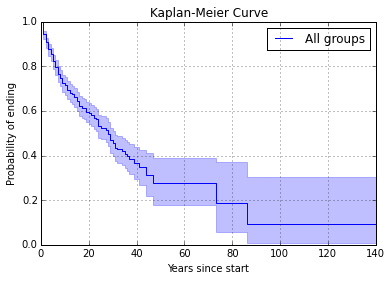

In [117]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
#Plot the curve and assign labels
kmf.plot()
plt.ylabel('Probability of ending')
plt.xlabel('Years since start')
plt.title('Kaplan-Meier Curve')
#Print median survival time
print('Median survival',kmf.median_)

The median survival time for the groups in the dataset is 28 years. Until about year 45, the probability of survival declines steadily, but in the following period some groups persist until 70 years, and one group survived at least for 140 years (Ku Klux Klan (U.S.)).

Now we can look at the variables in turn and compare different survival curves. We will use a non-parametric method, the log-rank analysis to test the difference. The log-rank test assumes that the hazards of the groups are proportional. Under the null hypothesis, the probability of event across the groups is the same for all time points. To test the null hypothesis, the log-rank test calculates the difference between the observed number of events and the number of events expected in each group proportional to the size of the groups at each time point an event is observed. The log-rank test statistic for group $j$ $(k_{j})$ follows a $\chi^2$ distribution and is calculated as:

$$k_{j} = \frac{(O_{j}-E_{j})^{2}}{var(O_{j}-E_{j})}$$

$O_{j}-E_{j}$ is calculated as:

$$O_{j}-E_{j} = \sum_{i}(o_{ij}-e_{ij})$$ 

and $var(O_{j}-E_{j})$ is:

$$var(O_{j}-E_{j}) = o_{i}\frac{n_{ij}}{n{i}}\Big(1-\frac{n_{ij}}{n{i}}\Big)\frac{(n_{i}-o_{i})}{(n_{i}-1)}$$

$o_{ij}$ is the observed number of events in group $j$ at time $i$ and $e_{ij}$ is the expected number of events in group $j$ at time $i$, which is calculated as $e_{ij} = \frac{n_{ij}}{n_i}{o_{i}}$. Note that $\frac{n_{ij}}{n_i}$ is the proportion of units in group $j$ at risk of event at time $i$ ($n_{ij}$) to the number of units in all groups at risk of event at time $i$ ($n_{i}$) and ${o_{i}}$ is the observed number of events in all groups at time $i$.  

When comparing multiple groups, we first calculate the pairwise log-rank test scores between each of the $k-1$ groups, and write them as a vector of log-rank statistics, $\bf{Z}$ which has $k - 1$ elements. We can leave any of one of the statistics out, because the $k$ covariances are linearly dependent on each other (the sum of log-rank statistics is 0, $\sum k_{j}=0$.

The test statistic for the hypothesis that there is no difference in survival times of $k$ groups is calculated as: 

$$logrankstatistic = \bf{Z} \sideset{_}{^{-1}}\sum \bf{Z}'$$ 

which has a $\chi^2$ distribution, where $\sideset{_}{^{-1}}\sum$ is the inverse of the $k-1$ by $k-1$ variance-covariance matrix of $\bf{Z}$, which has variance of $k_{j}$ on its diagonal elements and $covar(k_{jg})$ on its off-diagonal elements.

The variance of observed number of events in group $j$ is calculated as $var(O_{j}-E_{j})$ as demonstrated above. The covariance between the observed number of events in group $j$ and $g$ is calculated as:

$$covar(k_{jg})=o_{i}\frac{(n_{ij}n_{ig})}{(n_{i}n_{i})}\frac{(n_{i}-o_{i})}{(n_{i}-1)}$$

Note that rejecting the null hypothesis means that the survival times of groups do not come from the same distribution, it does not specify which group's survival time is different. The following plots and test statistics compare the groups in the dataset in terms of the five explanatory variables: operating peak size, economy, regime, type and goal. Astatistically significant log-rank test statistic indicates that we can reject the null hypothesis that time to survival in all groups come from the same distribution.

('Median survival: 10s', 29.0)
('Median survival: 100s', 24.0)
('Median survival: 1,000s', 34.0)
('Median survival: 10,000s', 22.0)
Results
   df: 3
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.10044 |              6.241 |  Cannot Reject Null |       False       


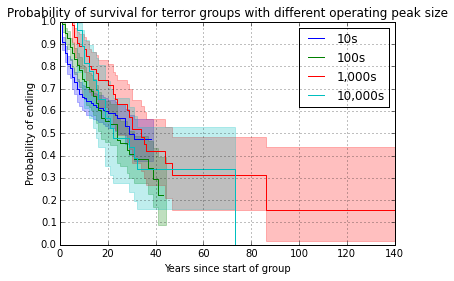

In [118]:
#Create boolean arrays to specify which groups will be included each K-M plot
tens = (survivaldata['10s'] == 1)
hundreds = (survivaldata['100s'] == 1)
thousands = (survivaldata['1,000s'] == 1)
tenthousands = ((survivaldata['10s'] == 0) & (survivaldata['100s'] == 0) & (survivaldata['1,000s'] == 0))
#Start a new plot
plt.figure()
ax = plt.subplot(1,1,1)
#Fit the K-M curve to observations for which Peak Operating Size = 10s
kmf.fit(timevar[tens],event_observed = eventvar[tens],label = "10s")
print('Median survival: 10s',kmf.median_)
plot1 = kmf.plot(ax = ax)
#Fit the K-M curve to observations for which Peak Operating Size = 100s
kmf.fit(timevar[hundreds],event_observed = eventvar[hundreds],label = "100s")
print('Median survival: 100s',kmf.median_)
plot2 = kmf.plot(ax = plot1)
#Fit the K-M curve to observations for which Peak Operating Size = 1,000s
kmf.fit(timevar[thousands],event_observed = eventvar[thousands],label = "1,000s")
print('Median survival: 1,000s',kmf.median_)
plot3 = kmf.plot(ax = plot2)
#Fit the K-M curve to observations for which Peak Operating Size = 10,000s
kmf.fit(timevar[tenthousands],event_observed = eventvar[tenthousands],label = "10,000s")
print('Median survival: 10,000s',kmf.median_)
plot4 = kmf.plot(ax = plot3)
plt.title('Probability of survival for terror groups with different operating peak size')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(terrordata['Time'],terrordata['Operating Peak Size'],terrordata['Ended'],alpha = 0.95)
twoplusgroups_logrank.print_summary()

The log-rank statistic does not reject the null hypothesis that at least one group's hazard is different than the others at least for some time. However, the median survival times and the difference between the survival curves indicate that the groups with different peak size groups might indeed have different hazard of ending. This discrepancy between the log-rank test result and the plots might be caused by the violation of the proportional hazards assumption: the ratio between the hazards (not survival times) of different groups are not constant during the observed time period. It is possible to look at a plot of $log(-log(S(t)))$ vs. $log(t)$ and see if the curves are parallel to each other to see whether the hazards are proportional (see section 3). As we will see later, the curves for $log(-(log(S(t)))$ vs. $log(t)$ indeed cross each other for groups with different peak operating sizes. This might be the reason why the log-rank test did not detect a difference. Note that the log-rank test compares the differences between the obseved and expected events. Even though the survival curves are different (as seen in the plot above) the total observed of events might be close to the expected number of events (for example, one group might have more events in one time period but fewer events in the following time period) reducing the power of the log-rank statistic to detect differences. 

('Median survival: Low income', 30.0)
('Median survival: Lower middle income', 30.0)
('Median survival: Upper middle income', 20.0)
('Median survival: High income', 27.0)
Results
   df: 3
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.06813 |              7.121 |  Cannot Reject Null |       False       


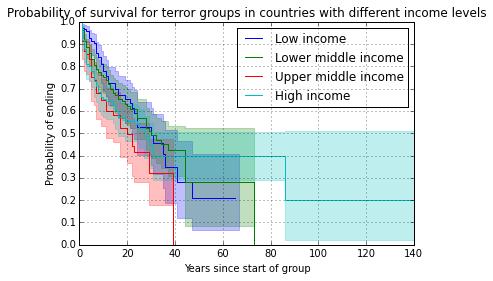

In [119]:
#Create boolean arrays to specify which groups will be included each K-M plot
low = (survivaldata['Low_income'] == 1)
lowermiddle = (survivaldata['Lower_middle_income'] == 1)
uppermiddle = (survivaldata['Upper_middle_income'] == 1)
high = ((survivaldata['Low_income'] == 0) & (survivaldata['Lower_middle_income'] == 0) & (survivaldata['Upper_middle_income'] == 0))
#Start a new plot
plt.figure()
ax = plt.subplot(1,1,1)
#Fit the K-M curve to observations for which Economy = low
kmf.fit(timevar[low],event_observed = eventvar[low],label = "Low income")
print('Median survival: Low income',kmf.median_)
plot1 = kmf.plot(ax = ax)
#Fit the K-M curve to observations for which Economy = Lower middle income
kmf.fit(timevar[lowermiddle],event_observed = eventvar[lowermiddle],label = "Lower middle income")
print('Median survival: Lower middle income',kmf.median_)
plot2 = kmf.plot(ax = plot1)
#Fit the K-M curve to observations for which Economy = Upper middle income
kmf.fit(timevar[uppermiddle],event_observed = eventvar[uppermiddle],label = "Upper middle income")
print('Median survival: Upper middle income',kmf.median_)
plot3 = kmf.plot(ax = plot2)
#Fit the K-M curve to observations for which Economy = High income
kmf.fit(timevar[high],event_observed = eventvar[high],label = "High income")
print('Median survival: High income',kmf.median_)
plot4 = kmf.plot(ax = plot3)
plt.title('Probability of survival for terror groups in countries with different income levels')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(terrordata['Time'],terrordata['Econ.'],terrordata['Ended'],alpha = 0.95)
twoplusgroups_logrank.print_summary()

The log-rank test does not reject the null hypothesis that survival time distributions do not differ by the income level of the country. However, the p-value is quite close to our significance cutoff value of 0.05 and the plots and the median survival times suggest that terrorist groups operating against low income countries last longer than those fighting against upper middle income countries. In section 3, we will see that the proportional hazards assumption for groups operating in countries with different income is not met. This might be the reason why the test failed to detect the difference between the hazards.

('Median survival: Free', 27.0)
('Median survival: Partly Free', 29.0)
('Median survival: Not Free', 28.0)
Results
   df: 2
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.52727 |              1.280 |  Cannot Reject Null |       False       


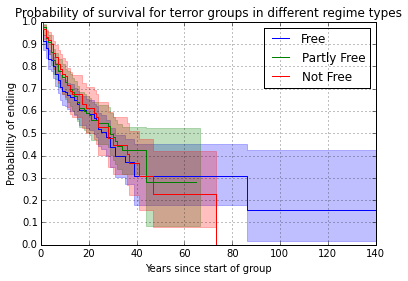

In [120]:
#Create boolean arrays to specify which groups will be included each K-M plot
free = (survivaldata['Free'] == 1)
partlyfree = (survivaldata['Partly_free'] == 1)
notfree = ((survivaldata['Free'] == 0) & (survivaldata['Partly_free'] == 0))
#Start a new plot
plt.figure()
ax = plt.subplot(1,1,1)
#Fit the K-M curve to observations for which regime = Free
kmf.fit(timevar[free],event_observed = eventvar[free],label = "Free")
print('Median survival: Free',kmf.median_)
plot1 = kmf.plot(ax = ax)
#Fit the K-M curve to observations for which regime = Partly_free
kmf.fit(timevar[partlyfree],event_observed = eventvar[partlyfree],label = "Partly Free")
print('Median survival: Partly Free',kmf.median_)
plot2 = kmf.plot(ax = plot1)
#Fit the K-M curve to observations for which regime = Not_free
kmf.fit(timevar[notfree],event_observed = eventvar[notfree],label = "Not Free")
print('Median survival: Not Free',kmf.median_)
kmf.plot(ax = plot2)
plt.title('Probability of survival for terror groups in different regime types')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(terrordata['Time'],terrordata['Regime'],terrordata['Ended'],alpha = 0.95)
twoplusgroups_logrank.print_summary()

An interesting result is that the survival times of groups under different regimes are not statistically different from each other. The plots indicate that the survival times of groups under free, partly-free and non-free regimes are very similar. Until about 23 years, it looks like the groups operating against free regimes have a shorter survival duration, but the different is too small to be declared as significant, and effectively disappears after year 23. The plot also suggests that the survival times of groups under partly-free and non-free regimes are very similar. Please note that looking at the plots like this does not allow for controlling for different group characteristics at the same time. Semi-parametric (section 3) or parametric (section 4) methods are necessary to control for the variables in the dataset. 

('Median survival: Nationalist', 30.0)
('Median survival: Religious', inf)
('Median survival: Right wing', 9.0)
('Median survival: Left wing', 20.0)
Results
   df: 3
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |             38.592 |      Reject Null    |        True       


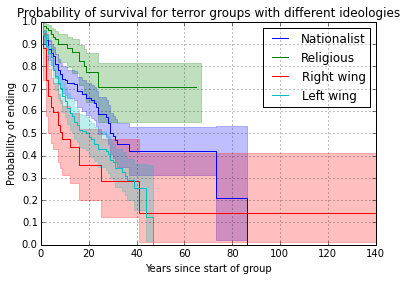

In [121]:
#Create boolean arrays to specify which groups will be included each K-M plot
nationalist = (survivaldata['Nationalist'] == 1)
religious = (survivaldata['Religious'] == 1)
right_wing = (survivaldata['Right_wing'] == 1)
left_wing = ((survivaldata['Nationalist'] == 0) & (survivaldata['Religious'] == 0) & (survivaldata['Right_wing'] == 0))
#Start a new plot
plt.figure()
ax = plt.subplot(1,1,1)
#Fit the K-M curve to observations for which Type = Nationalist
kmf.fit(timevar[nationalist],event_observed = eventvar[nationalist],label = "Nationalist")
print('Median survival: Nationalist',kmf.median_)
plot1 = kmf.plot(ax = ax)
#Fit the K-M curve to observations for which Type = Religious
kmf.fit(timevar[religious],event_observed = eventvar[religious],label = "Religious")
print('Median survival: Religious',kmf.median_)
plot2 = kmf.plot(ax = plot1)
#Fit the K-M curve to observations for which Type = Right_wing
kmf.fit(timevar[right_wing],event_observed = eventvar[right_wing],label = "Right wing")
print('Median survival: Right wing',kmf.median_)
plot3 = kmf.plot(ax = plot2)
#Fit the K-M curve to observations for which Type = Left_wing
kmf.fit(timevar[left_wing],event_observed = eventvar[left_wing],label = "Left wing")
print('Median survival: Left wing',kmf.median_)
plot4 = kmf.plot(ax = plot3)
plt.title('Probability of survival for terror groups with different ideologies')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(terrordata['Time'],terrordata['Type'],terrordata['Ended'],alpha = 0.95)
twoplusgroups_logrank.print_summary()

Log-rank statistic indicates that groups with different ideologies have different survival times. From the plot it looks like religious groups last longer than right wing groups in general. One exception is the Ku Klux Klan, which has survived for at least 140 years. Note that the median survival time for religious groups is 'infinity' since we do not observe the median survival time for these groups in the dataset.

('Median survival: Territorial change', 37.0)
('Median survival: Policy change', 29.0)
('Median survival: Empire', 73.0)
('Median survival: Social revolution', 20.0)
('Median survival: Status_Quo', 12.0)
('Median survival: Regime change', 21.0)
Results
   df: 5
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00078 |             21.087 |      Reject Null    |        True       


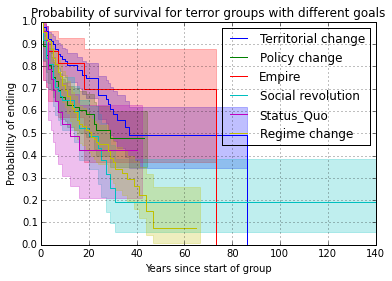

In [122]:
#Create boolean arrays to specify which groups will be included each K-M plot
territorial = (survivaldata['Territorial_change'] == 1)
policy = (survivaldata['Policy_change'] == 1)
empire = (survivaldata['Empire'] == 1)
social = (survivaldata['Social_revolution'] == 1)
status = (survivaldata['Status_Quo'] == 1)
regime = (survivaldata['Territorial_change'] == 0) & (survivaldata['Policy_change'] == 0) & (survivaldata['Empire'] == 0) & (survivaldata['Social_revolution'] == 0) & (survivaldata['Status_Quo'] == 0)
#Start a new plot
plt.figure()
ax = plt.subplot(1,1,1)
#Fit the K-M curve to observations for which Goal = Territorial_change
kmf.fit(timevar[territorial],event_observed = eventvar[territorial],label = "Territorial change")
print('Median survival: Territorial change',kmf.median_)
plot1 = kmf.plot(ax = ax)
#Fit the K-M curve to observations for which Goal = Policy_change
kmf.fit(timevar[policy],event_observed = eventvar[policy],label = "Policy change")
print('Median survival: Policy change',kmf.median_)
plot2 = kmf.plot(ax = plot1)
#Fit the K-M curve to observations for which Goal = Empire
kmf.fit(timevar[empire],event_observed = eventvar[empire],label = "Empire")
print('Median survival: Empire',kmf.median_)
plot3 = kmf.plot(ax = plot2)
#Fit the K-M curve to observations for which Goal = Social_revolution
kmf.fit(timevar[social],event_observed = eventvar[social],label = "Social revolution")
print('Median survival: Social revolution',kmf.median_)
plot4 = kmf.plot(ax = plot3)
#Fit the K-M curve to observations for which Goal = Status Quo
kmf.fit(timevar[status],event_observed = eventvar[status],label = "Status_Quo")
print('Median survival: Status_Quo',kmf.median_)
plot5 = kmf.plot(ax = plot4)
#Fit the K-M curve to observations for which Goal = Regime_change
kmf.fit(timevar[regime],event_observed = eventvar[regime],label = "Regime change")
print('Median survival: Regime change',kmf.median_)
plot6 = kmf.plot(ax = plot5)
plt.title('Probability of survival for terror groups with different goals')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(terrordata['Time'],terrordata['Goal'],terrordata['Ended'],alpha = 0.95)
twoplusgroups_logrank.print_summary()

It looks like there is a statistically significant difference between the survival times of groups with different goals. The K-M plots suggest that groups that aim for territorial change or an empire last longer than those who aim for the status quo.

K-M plots and log-rank test are widely used for comparison of survival data. However, looking only at K-M curves might be misleading, since we are not controlling for other factors when calculating the survival probabilities. Log-rank test assumes that the hazards are proportional, and when this assumption does not hold, the test might not detect the differences between the groups. We next turn to Cox proportional hazards model, a semi-parametric method that allows for controlling for different covariates. We will also analyze residuals and use log-log plots to assess the proportionality of hazards assumption.

##3) Semi-parametric Methods

Cox proportional hazard model estimates the hazard ratio of covariates with respect to a refence value, under the assumption that the estimated hazard ratios are constant (they do not depend on time) although the hazards might change. 

$$h(t)=h_{0}e^{\bf{X^{T}}\bf{\beta}}$$

where $h_{0}$ is the baseline hazard and $e^{\bf{X^{T}}\bf{\beta}}$ is the hazard ratio, $\bf{X}$ are the covariates and $\bf{\beta}$ are the coefficients. The baseline hazard $h_{0}$ is unspecified and is left out of the likelihood function. For this reason the Cox proportional hazards model has a partial likelihood function:

$$ L(\beta)=\prod_{i=1}^{n}\Bigg[\frac{e^{x_{i}^{T}\beta}}{\sum_{k\in{R(t_{i})}}e^{x_{k}^{T}\beta}}\Bigg]^{d_{i}} $$

where $d_{i}$ is the censoring variable that equals to 1 if the an event occured at time $t_{i}$ and to 0 if the unit was censored at time $t_{i}$. Therefore only the units that experience the event contribute to the likelihood function. In the Cox proportional hazards likelihood function, the numerator is the hazard of unit $i$, and the denominator is the sum of the hazards of all units that are still under risk of event (did not experience the event and was not censored before the time at which unit $i$ experienced the event). Note that these hazards do not depend on the value of $t$, it is only the ordering of $t$ that matters.

The assumption is that each event time is unique, and there is only one possible value for the partial likelihood at time $i$. This assumption does not hold for many types of data, including the data set we are working with here. Many groups ended within the first year of their start (these are assumed to have a survival time of 1 year). Because we do not have more precise information on survival times which would have allowed us to have uniqe event times for the groups who have ended, we have to use an approximation method. 
  
The first approximation method is the 'exact method' which finds the likelihood function value for a survival time $i$ as the sum of the probability of each permutation of event time orderings at that time. But this method is computationally too expensive. Instead Efron approximation is often used. Efron approximation likelihood is given by:

$$ L(\beta)=\prod_{i=1}^{n}\Bigg[\frac{e^{x_{i}\beta}}{\prod_{k=1}^{d_{1}}(\sum_{j\in{R_{t_{i}}}} e^{x_{j}\beta}-\frac{k-1}{d_{i}}\sum_{j\in{D_{t_{i}}}}e^{x_{j}\beta})}\Bigg]^{d_{i}}$$

where $d_{i}$ is the number of ties at time $t_{i}$, $D_{t_{i}}$ denotes the units that experienced the event at time $t_{i}$ and $R_{t_{i}}$ denotes the units that are still at risk of event at time $t_{i}$. We can use the CoxPHFitter from Lifelines package to fit a Cox proportional hazards model. The default approximation method in CoxPHFitter is the Efron approximation.

In [123]:
#CoxPHFitter takes a dataframe that includes time and event 
#variables
survivaldata_time_event = survivaldata.copy()
#Remove the constant term, since the Cox proportional hazards model does not estimate a parameter for the constant term
survivaldata_time_event = survivaldata_time_event.iloc[:,:-1]
#Add the time and censoring variables to the dataframe
survivaldata_time_event['Time'] = timevar
survivaldata_time_event['Event'] = eventvar
#Create the CoxPHFitter object
cf = CoxPHFitter()
#Fit the model
cf.fit(survivaldata_time_event, 'Time', event_col='Event',include_likelihood = True)
#Print the summary from the cox-proportional hazard model
cf.print_summary()

n=648, number of events=243

                          coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
Territorial_change  -2.941e-01  7.452e-01 1.002e-01 -2.936e+00 3.329e-03  -4.904e-01  -9.769e-02   **
Policy_change       -7.985e-02  9.233e-01 7.653e-02 -1.043e+00 2.967e-01  -2.299e-01   7.017e-02     
Empire              -9.692e-03  9.904e-01 8.712e-02 -1.112e-01 9.114e-01  -1.805e-01   1.611e-01     
Social_revolution   -1.136e-02  9.887e-01 7.534e-02 -1.508e-01 8.801e-01  -1.591e-01   1.363e-01     
Status_Quo          -3.772e-02  9.630e-01 6.394e-02 -5.900e-01 5.552e-01  -1.631e-01   8.763e-02     
1,000s              -6.789e-02  9.344e-01 1.033e-01 -6.570e-01 5.112e-01  -2.705e-01   1.347e-01     
100s                 1.311e-01  1.140e+00 1.258e-01  1.042e+00 2.974e-01  -1.155e-01   3.777e-01     
10s                  1.375e-01  1.147e+00 1.423e-01  9.664e-01 3.339e-01  -1.415e-01   4.165e-01     
Low_income           3.252e-02  1.033e+00 1.034e-01  

The Cox model suggests that only 'Territorial change' and 'Religious' have significant impact on the hazard of ending, after controlling for all the other variables. Hazard for ending for groups that want territorial change is 0.745 of those who want regime change (the reference category that is left out of the equation). Similarly, religious groups are subject to only 0.62 times the hazard faced by left wing groups at any time. 

These results assume that the risks faced by different groups are proportional to each other. Two ways to test the proportionality assumption are calculating Schoenfeld residuals and plotting log(-log(S(t))) vs. log(time).

We first check whether Schoenfeld residuals are correlated with time to test the proportional hazard assumption. Schoenfeld residuals are defined for each covariate of each individual who experience the event and they equal to the difference between the covariate value of the unit at the time of failure and the expected value of the covariate at the time of failure. The expected value of a covariate is found by multiplying the covariate values of all units still at risk of failure at the time of failure by the probabilities of failure of units. Probability of failure of a unit is calculated by:

$$ P(j\,fails) = \frac{e^{\beta x_{j}}}{\sum_{g\in\mathcal{R_{(t)}}}e^{\beta x_{g}}}$$

where $e^{\beta x_{j}}$ is the hazard of individual $j$ and ${\sum_{g\in\mathcal{R_{(t)}}}e^{\beta x_{g}}}$ is the sum of hazards of all units still at risk of failure (which did not fail and was not lost to follow-up before the time of failure of $j$).

The expected value of the covariate is found by multiplying the probabilities of failure of each unit at risk of failure by their covariate values. 

$$ E(X)=\frac{\sum_{j\in\mathcal{R_{(t)}}}x_{j}e^{\beta x_{j}}}{\sum_{g\in\mathcal{R_{(t)}}}e^{\beta x_{g}}}$$

$$ \hat{r_{j}}=x_{j}-E(X) $$

The scaled Schoenfeld residuals are calculated by weighting the residuals by the variance covariance of covariates.

$$ \hat{r_{j}}= M var(\beta) \hat{r_{j}} $$

where $M$ is the number of events.

If the proportional assumptions hold, scaled schoenfeld residuals should not be correlated with time. 

In [124]:
#This is the function that returns scaled schoenfeld residuals
#y is the 'time' variable, 'X' is the n by p data matrix, 
#'params' is the parameter values from the Cox proportional hazard model
#'covar' is the variance-covariance matrix from the Cox proportional
#hazard model
def schoenfeldresiduals(y,X,event,params,covar):
    #Create a dataframe to hold the scaled Schoenfeld residuals
    schoenfeldresiduals = pd.DataFrame(columns=[X.columns])
    #Create a dataframe to hold the 'Time variable'
    schoenfeldtime = pd.DataFrame(columns=['Time'])
    #Add the 'Time' variable to the data matrix 'X'. This will be
    #useful to select units still at risk of event
    X['Time'] = y
    #Add the 'event' variable to the data matrix 'X'. This will be
    #useful to select units who experienced the event
    X['Eventoccured'] = event
    #Sort 'X' based on time (ascending order)
    X = X.sort(['Time'],axis = 0)
    #Get the number of units
    numberofunits = len(X)
    #Set the counter to zero
    counter = 0
    #Get the number of units that experienced the event
    numberofevents = np.sum(event)
    #For each unit, calculate the residuals if they experienced the event
    for patientindex in xrange(numberofunits):
        if X['Eventoccured'].iloc[patientindex] == 1:
            currenttime = X['Time'].iloc[patientindex]
            #Sum of the hazards for all the observations still at risk
            sumhazards = np.sum(np.exp(np.dot(X.loc[X['Time'] >= currenttime].iloc[:,:len(X.columns) - 2],params)))
            #Calculate the probability of event for each unit still at risk
            probabilityofdeathall = np.ravel(np.exp(np.dot(X.loc[X['Time'] >= currenttime].iloc[:,:len(X.columns) - 2],params)) / sumhazards)         
            #Calculate the expected covariate values
            expectedcovariatevalues = np.dot(probabilityofdeathall,X.loc[(X['Time'] >= currenttime)].iloc[:,:len(X.columns) - 2])
            #Get Schoenfeld residuals as the difference between the current unit's covariate values and the 
            #expected covariate values calculated from all units at risk
            residuals = X.iloc[patientindex,:len(X.columns) - 2] - expectedcovariatevalues
            #Scale the residuals by the variance-covariance matrix of model parameters
            scaledresiduals = numberofevents * np.dot(covar,residuals)
            #Add the scaled residuals to the dataframe for residuals
            schoenfeldresiduals.loc[counter]= scaledresiduals
            #Add the current time for the current unit. This can be used to regress scaled residuals against time
            schoenfeldtime.loc[counter] = currenttime          
            counter = counter + 1
    schoenfeldresiduals['Time'] = schoenfeldtime
    return schoenfeldresiduals

We now calculate the schoenfeld residuals by using the function above.

In [125]:
residuals = schoenfeldresiduals(timevar,survivaldata.iloc[:,:-1],eventvar,cf.hazards_.transpose(),cf.covar())   

Now that we have the scaled schoenfeld residuals for all groups who failed and for each covariate, we can plot them and regress them against time to see if there is a statistically significant correlation. Residuals dispersed randomly around 0 and non-significant correlation coefficients between time and residuals indicate that the proportional hazards assumption holds. A significant coefficient indicates that the proportional hazard is not a suitable assumption (the proportion of risk changes with time).

                            OLS Regression Results                            
Dep. Variable:     Territorial_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1207
Date:                Sat, 14 Nov 2015   Prob (F-statistic):              0.729
Time:                        18:58:22   Log-Likelihood:                -271.69
No. Observations:                 243   AIC:                             547.4
Df Residuals:                     241   BIC:                             554.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Time           0.0014      0.004      0.347      0.7

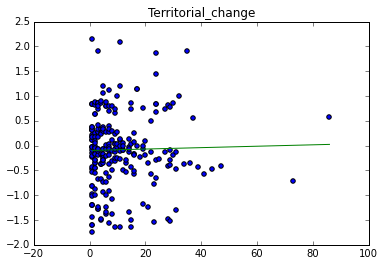

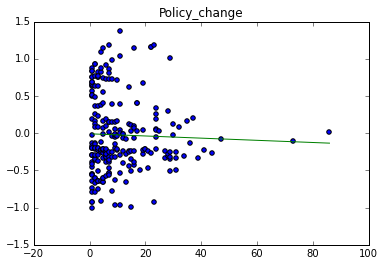

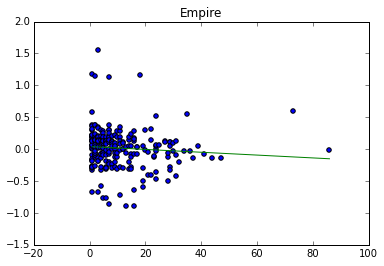

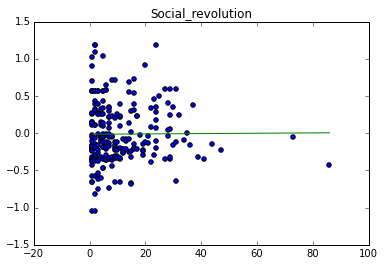

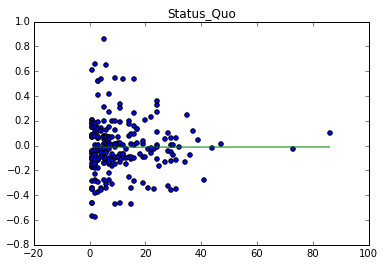

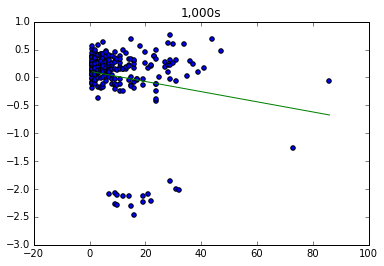

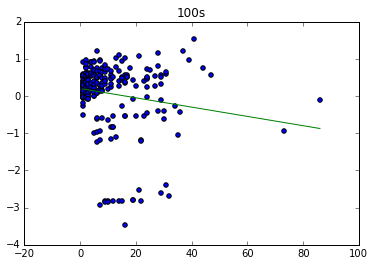

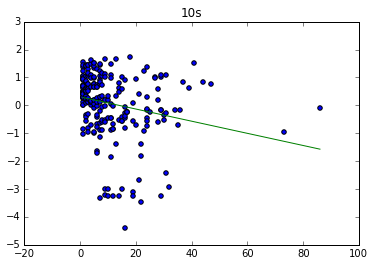

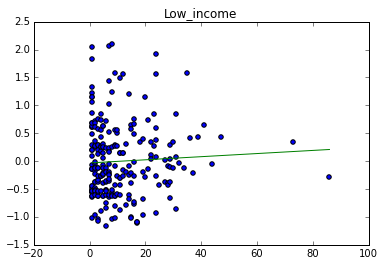

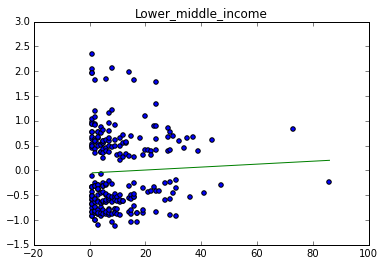

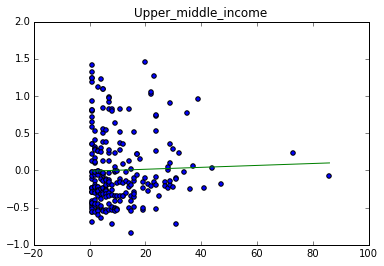

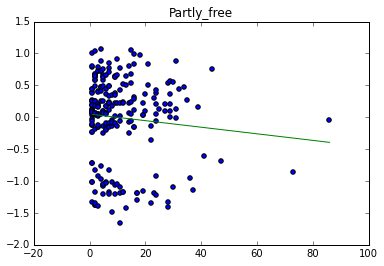

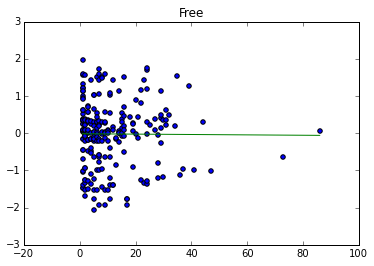

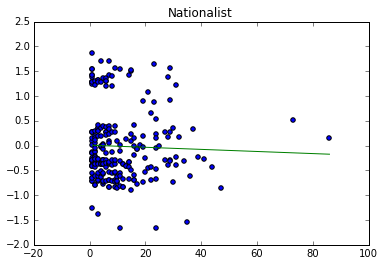

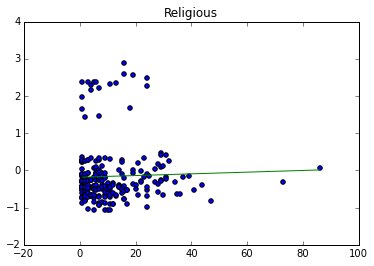

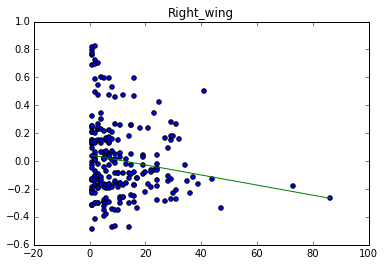

In [126]:
#Start plotting the scaled residuals against time
plt.figure()
plt.scatter(residuals['Time'],residuals['Territorial_change'])
plt.title('Territorial_change')
#Fit a linear model to scaled residuals and time data, after adding a constant
#to 'Time'
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Territorial_change'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

#Repeat for residuals from other variables
plt.figure()
plt.scatter(residuals['Time'],residuals['Policy_change'])
plt.title('Policy_change')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Policy_change'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Empire'])
plt.title('Empire')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Empire'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Social_revolution'])
plt.title('Social_revolution')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Social_revolution'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Status_Quo'])
plt.title('Status_Quo')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Status_Quo'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['1,000s'])
plt.title('1,000s')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['1,000s'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['100s'])
plt.title('100s')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['100s'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['10s'])
plt.title('10s')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['10s'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Low_income'])
plt.title('Low_income')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Low_income'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Lower_middle_income'])
plt.title('Lower_middle_income')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Lower_middle_income'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Upper_middle_income'])
plt.title('Upper_middle_income')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Upper_middle_income'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Partly_free'])
plt.title('Partly_free')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Partly_free'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Free'])
plt.title('Free')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Free'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Nationalist'])
plt.title('Nationalist')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Nationalist'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Religious'])
plt.title('Religious')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Religious'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

plt.figure()
plt.scatter(residuals['Time'],residuals['Right_wing'])
plt.title('Right_wing')
X = st.add_constant(residuals['Time'],prepend = False)
linearmodel = st.OLS(residuals['Right_wing'],X)
linearmodelresults = linearmodel.fit()
plt.plot(residuals['Time'],linearmodelresults.fittedvalues,'g')
print(linearmodelresults.summary())

Plots and the regressions suggest that the proportional hazards assumption does not hold for '1,000s', '100s', '10s' and 'Right wing' variables. These values do not suggest that we should reject the proportionality assumption for 'Territorial change' and 'Religious' variables.

Another method to check the proportional hazards assumption is to check the plot of log(-log(S(t))) against log(time) where S(t) is calculated by the Kaplan-Meier method described in section 2.

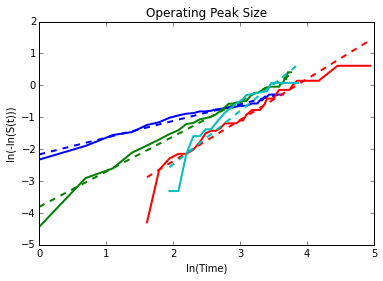

In [127]:
#Start plotting the log(-log(S(t))) against log(t). First, get the Kaplan-Meier estimates for S(t).
plt.figure()
kmf.fit(timevar[tens],event_observed = eventvar[tens],label = "Tens")
#Plot the log(-log(S(t))) against log(t)
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Tens'])),linewidth = 2.0)
#Fit a linear equation for easier visual assessment of the plots
y = np.log(-np.log(kmf.survival_function_['Tens'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

#Repeat for groups of different peak operating sizes
kmf.fit(timevar[hundreds],event_observed = eventvar[hundreds],label = "Hundreds")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Hundreds'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Hundreds'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[thousands],event_observed = eventvar[thousands],label = "Thousands")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Thousands'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Thousands'].iloc[5:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[5:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[tenthousands],event_observed = eventvar[tenthousands],label = "Ten thousands")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Ten thousands'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Ten thousands'].iloc[3:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[3:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Operating Peak Size')

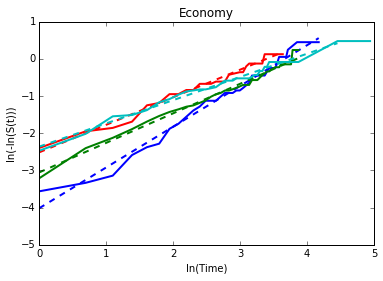

In [128]:
#Repeat for groups operating against countries with different income levels
plt.figure()
kmf.fit(timevar[low],event_observed = eventvar[low],label = "Low")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Low'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Low'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[lowermiddle],event_observed = eventvar[lowermiddle],label = "Lower middle")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Lower middle'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Lower middle'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[uppermiddle],event_observed = eventvar[uppermiddle],label = "Upper middle")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Upper middle'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Upper middle'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[high],event_observed = eventvar[high],label = "High")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['High'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['High'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Economy')

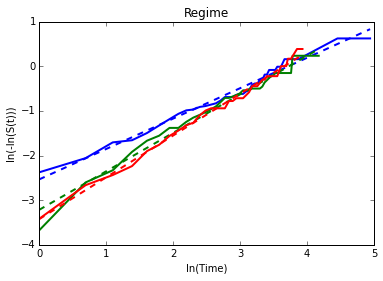

In [129]:
#Repeat for groups operating against countries with different freedom index values
plt.figure()
kmf.fit(timevar[free],event_observed = eventvar[free],label = "Free")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Free'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Free'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[partlyfree],event_observed = eventvar[partlyfree],label = "Partly free")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Partly free'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Partly free'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[notfree],event_observed = eventvar[notfree],label = "Not free")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Not free'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Not free'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Regime')

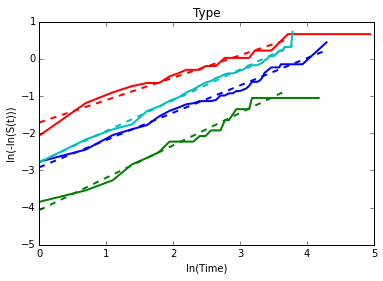

In [130]:
#Repeat for groups with different ideologies
plt.figure()
kmf.fit(timevar[nationalist],event_observed = eventvar[nationalist],label = "Nationalist")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Nationalist'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Nationalist'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[religious],event_observed = eventvar[religious],label = "Religious")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Religious'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Religious'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[right_wing],event_observed = eventvar[right_wing],label = "Right wing")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Right wing'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Right wing'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[left_wing],event_observed = eventvar[left_wing],label = "Left wing")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Left wing'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Left wing'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Type')

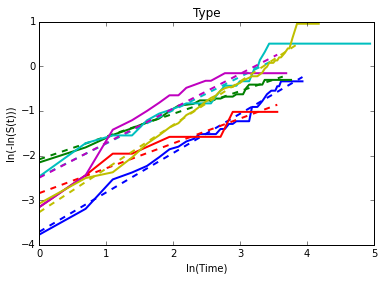

In [131]:
#Repeat for groups with different goals
plt.figure()
kmf.fit(timevar[territorial],event_observed = eventvar[territorial],label = "Territorial change")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Territorial change'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Territorial change'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'b--',linewidth = 2.0)

kmf.fit(timevar[policy],event_observed = eventvar[policy],label = "Policy change")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Policy change'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Policy change'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

kmf.fit(timevar[empire],event_observed = eventvar[empire],label = "Empire")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Empire'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Empire'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'r--',linewidth = 2.0)

kmf.fit(timevar[social],event_observed = eventvar[social],label = "Social revolution")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Social revolution'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Social revolution'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'c--',linewidth = 2.0)

kmf.fit(timevar[status],event_observed = eventvar[status],label = "Status Quo")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Status Quo'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Status Quo'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'m--',linewidth = 2.0)

kmf.fit(timevar[regime],event_observed = eventvar[regime],label = "Regime change")
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['Regime change'])),linewidth = 2.0)
y = np.log(-np.log(kmf.survival_function_['Regime change'].iloc[1:len(kmf.survival_function_)-1]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)-1])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'y--',linewidth = 2.0)

plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Type')

Plots and the regression results indicate that the proportionality of hazards assumption does not hold for '1,000s', '100s' and '10s', and 'right wing' variables, consistent with the results from scaled residual variables.

Next, we will use parametric methods to model the time to end data.

## 4) Parametric Methods

Unlike semi-parametric methods that leave the baseline hazard unspecified, parametric methods make assumptions about the shape of the hazard. Therefore they are fit by using the full likelihood function. 

$$ll_{i}=d_{i}log(h(t_{i}))-H(t_{i})$$

where $ll_{i}$ is the contribution of unit $i$ to the likelihood function, $d_{i}$ is the censoring parameter that equals 1 if unit $i$ experienced the event and equals 0 if the unit was censored, $h(t_{i})$ is the hazard function for unit $i$ which experienced the event or was censored at time $t_{i}$ and $H(t_{i})$ is the cumulative hazard function for unit $i$. 

We will first model the survival for the entire group without using covariates. We will try Exponential, Weibull, Gompertz, Loglogistic, Lognormal and Generalized Gamma distributions. Before fitting the models, we can visually inspect plots of transformed empirical survival curves.

###Exponential Survival Model

Exponential distribution assumes a constant hazard rate. Exponential survival distribution is parameterized by $$S(t) = e^{-rt}$$ where $r$ is the hazard rate and $t$ is the time to event. The negative of the logarithm of this function is linear $-ln(S(t)) = rt$ with respect to time. Plotting the negative log of the empirical survival curve against time should give a linear plot. We include a linear fit between negative log of survival times for easier comparison. 

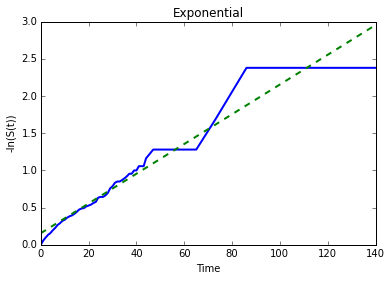

In [132]:
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
plt.figure()
plt.plot(kmf.survival_function_.index.values,-np.log(kmf.survival_function_['All groups']),linewidth = 2.0)
plt.ylabel('-ln(S(t))')
plt.xlabel('Time')
plt.title('Exponential')
y = -np.log(kmf.survival_function_['All groups'])
X = np.asarray(kmf.survival_function_.index.values)
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

The plot suggests that Exponential distribution is not a very good fit for the data, as there are substantial deviations from the straight line after around Time = 30. We now define the loglikelihood function for the exponential distribution and fit the model. We can use the GeneriLikelihoodModel from statsmodels package to specify the likelihood functions.

The loglikelihood function for the Exponential survival model is:

$$ll_{i}=d_{i} log(\mu) - \mu t$$

where $ll_{i}$ is the loglikelihood function for individual $i$, $d_{i}$ is the censoring variable that equals to 1 if unit $i$ experienced the event and to 0 if the unit was censored.

In [133]:
#Define the likelihood function.
#Although we are not using any covariates at this time, we use a vector of
#ones as the 'X' argument for the Generallikelihood function
def _ll_exponential(y,X,scale):
    ll = eventvar * np.log(scale) - (scale * y)
    return ll 
#The Exponential class uses the _ll_exponential function to iteratively update the 
#parameter values to maximiez the likelihood function
class Exponential(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Exponential, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponential(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(Exponential, self).fit(start_params = start_params,maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.711635
         Iterations: 17
         Function evaluations: 34
                             Exponential Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1109.1
Model:                    Exponential   AIC:                             2220.
Method:            Maximum Likelihood   BIC:                             2225.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:26                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------

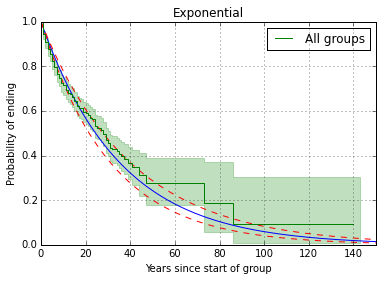

In [134]:
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
#Exponential
#Specify starting values for the parameters
start_params_var = np.repeat(0.5,1)
exp_data = np.repeat(1,len(timevar))
mod_exponential = Exponential(timevar,exp_data)
res_exp = mod_exponential.fit()
print(res_exp.summary())

#Plot the exponential prediction against the empirical survival curve
#Prediction intervals are calculated by complementary log - log transform
#of the survival prediction. The variance of the log - log of the survival
#term is approximated by the delta method, explained on the state website:
#www.stata.com/support/faqs/statistics/delta-method
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_exponential.predict_survival_exponential(res_exp.params, t))
plt.plot(t,mod_exponential.predict_survival_exponential_cis(res_exp.params, res_exp.bse, t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_exponential.predict_survival_exponential_cis(res_exp.params, res_exp.bse, t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Exponential')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Exponential.png',dpi = 300)

###Weibull Survival Model

Weibull survival function is parameterized as: $$ S(t) = e^{-rt^{\gamma}}$$

The $\gamma$ parameter indicates whether the hazard is increasing ($\gamma$ > 1) or decreasing ($\gamma$ < 1). Note that when $\gamma$ parameter equals to 1,we have an exponential distribution; the hazard is constant. 

The log negative log transformation of the Weibull survival is linear with respect to log time; $\gamma log(r) + \gamma log(t)$ vs. $log(t)$. Therefore, log-log transformation of the empirical survival data against log of time should give a linear plot. Again, we fit a linear function for easier assessment.

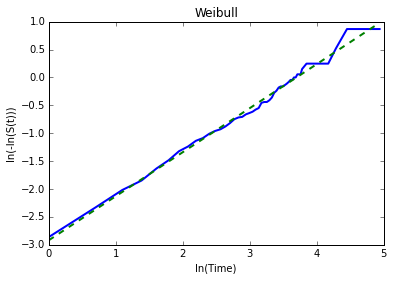

In [135]:
plt.figure()
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['All groups'])),linewidth = 2.0)
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Weibull')
y = np.log(-np.log(kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

The plot suggests that the Weibull distribution is a better fit, as it closely follows the linear fit, except towards the end of the curve. We now fit the Weibull model to data. 


The loglikelihood function for the Weibull survival model is:
    
$$ll_{i}=d_{i} log(\mu\gamma t^{\gamma-1}) - \mu t^{\gamma}$$

In [136]:
def _ll_weibull(y,X,scale,gamma):
    ll = eventvar * np.log(scale * gamma * np.power(y, (gamma - 1))) - (scale * np.power(y,gamma))
    return ll

class Weibull(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Weibull, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_weibull(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Weibull, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.708281
         Iterations: 48
         Function evaluations: 91
                               Weibull Results                                
Dep. Variable:                   Time   Log-Likelihood:                -1107.0
Model:                        Weibull   AIC:                             2216.
Method:            Maximum Likelihood   BIC:                             2220.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:27                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------

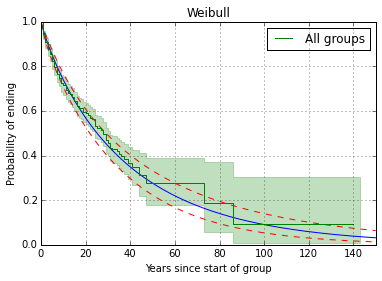

In [137]:
#Weibull
start_params_var = np.repeat(0.5,2)
weibull_data = np.repeat(1,len(timevar))
mod_weibull = Weibull(timevar,weibull_data)
res_wei = mod_weibull.fit()
print(res_wei.summary())

#Plot the weibull prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_weibull.predict_survival_weibull(res_wei.params, t))
plt.plot(t,mod_weibull.predict_survival_weibull_cis(res_wei.params, res_wei.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_weibull.predict_survival_weibull_cis(res_wei.params, res_wei.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Weibull')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Weibull.png',dpi = 300)

###Gompertz Survival Model

Gompertz survival distribution has two parameters, a scale parameter ($\lambda$) and a shape parameter ($\gamma$): $$ S(t)=e^{-\frac{( e^{\lambda} )\ (\ {e^{\gamma t} - 1})}{\lambda}} $$

The log of hazard is linear in gompertz distribution. The integral of the log hazard is linear with respect to time. The hazard of the gompertz survival is $$h(t)=e^{\lambda+\gamma t} $$

We can calculate the hazard at time $t$ from the empirical survival curve by subtracting the negative of the log of the survival probability at time $t_1$ ($-log(S(t_1)$) from the negative log of the survival probability at time $t_2$ ($-log(S(t_2)$)

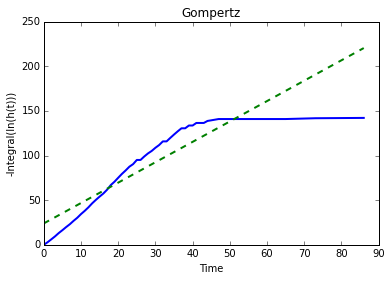

In [138]:
plt.figure()
t_1 = kmf.survival_function_.iloc[0:len(kmf.survival_function_) - 1]
t_2 = kmf.survival_function_.iloc[1:len(kmf.survival_function_)]
gompertz_hazard = []
gompertz_hazard.append(0)
for index in range(len(t_1)):
    #Because we are summing the log of the hazard, check if the 
    #hazard is zero between t_2 and t_1. 
    if (-np.log(t_2.iloc[index,0])+np.log(t_1.iloc[index,0])) > 0:
        gompertz_hazard.append(gompertz_hazard[index] - np.log(-np.log(t_2.iloc[index,0])+np.log(t_1.iloc[index,0])))
    else:
    #If it is, append the latest value of the cumulative hazard at time t_2
        gompertz_hazard.append(gompertz_hazard[index])
plt.plot(t_1.index.values,gompertz_hazard[:-1],linewidth = 2.0)
plt.title('Gompertz')
plt.ylabel('-Integral(ln(h(t)))')
plt.xlabel('Time')
y = gompertz_hazard[:-1]
X = t_1.index.values
X = st.add_constant(X,prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,0],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Gompertz distribution does not seem to be a good fit to data as it deviates from the line considerably.

The loglikelihood function for the Gompertz survival model is:

$$ll_{i}=d_{i} (\mu+\gamma t) - e^{\mu}(e^{\gamma t}-1)\gamma^{-1}$$

In [139]:
def _ll_gompertz(y,X,scale,gamma):
    ll = eventvar * (scale + gamma * y) - ((np.exp(scale) * (np.exp(gamma * y) - 1)) / gamma)    
    return ll

class Gompertz(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Gompertz, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_gompertz(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Gompertz, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.705453
         Iterations: 86
         Function evaluations: 166
                               Gompertz Results                               
Dep. Variable:                   Time   Log-Likelihood:                -1105.1
Model:                       Gompertz   AIC:                             2212.
Method:            Maximum Likelihood   BIC:                             2217.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:28                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

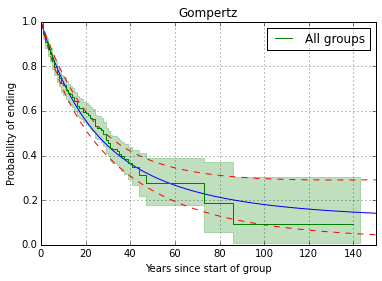

In [140]:
#Gompertz
start_params_var = [0,0]
gompertz_data = np.repeat(1,len(timevar))
mod_gompertz = Gompertz(timevar,gompertz_data)
res_gomp = mod_gompertz.fit()
print(res_gomp.summary())

#Plot the gompertz prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_gompertz.predict_survival_gompertz(res_gomp.params, t))
plt.plot(t,mod_gompertz.predict_survival_gompertz_cis(res_gomp.params, res_gomp.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_gompertz.predict_survival_gompertz_cis(res_gomp.params, res_gomp.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Gompertz')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Gompertz.png',dpi = 300)

###Loglogistic Survival Model

Loglogistic survival distribution is parameterized as $$S(t) = \frac{1}{{1+\lambda t^{\gamma}}}$$

The logarithm of the survival function divided by the cumulative distribution function (log odds of survival) is linear with respect to log of time: $$-log(\frac{S(t)}{1-S(t)}) = \gamma ln(\lambda) + \gamma ln(t) $$

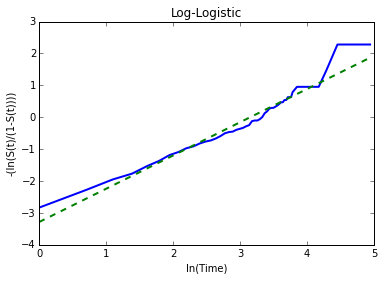

In [141]:
plt.figure()
plt.plot(np.log(kmf.survival_function_.index.values),-np.log(kmf.survival_function_['All groups']/(1-kmf.survival_function_['All groups'])),linewidth = 2.0)
plt.ylabel('Probability of ending')
plt.xlabel('Years')
plt.title('Log-Logistic')
plt.ylabel('-(ln(S(t)/(1-S(t))))')
plt.xlabel('ln(Time)')
y = -np.log(kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)]/(1-kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Overall, the loglogistic survival model does not deviate much from the data. 

Fit loglogistic model to data. The loglikelihood function for the loglogistic survival model is:

$$ll_{i}=d_{i} \frac{log(\mu \gamma t^{\gamma-1})}{1+\mu t^{\gamma}} + log\Bigg(\frac{1}{(1+\mu t^{\gamma})}\Bigg)$$

In [142]:
def _ll_loglogistic(y,X,scale,gamma):
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class Loglogistic(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Loglogistic, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_loglogistic(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Loglogistic, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.703526
         Iterations: 74
         Function evaluations: 140
                             Loglogistic Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1103.9
Model:                    Loglogistic   AIC:                             2210.
Method:            Maximum Likelihood   BIC:                             2214.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:28                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

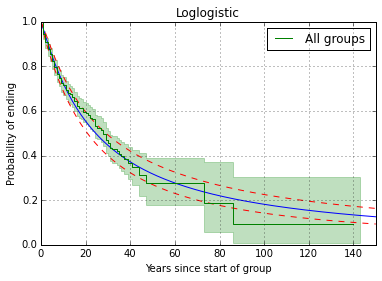

In [143]:
#Log-Logistic
start_params_var = [0,0]
loglogistic_data = np.repeat(1,len(timevar))
mod_loglogistic = Loglogistic(timevar,loglogistic_data)
res_loglog = mod_loglogistic.fit()
print(res_loglog.summary())

#Plot the loglogistic prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_loglogistic.predict_survival_loglogistic(res_loglog.params, t))
plt.plot(t,mod_loglogistic.predict_survival_loglogistic_cis(res_loglog.params, res_loglog.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_loglogistic.predict_survival_loglogistic_cis(res_loglog.params, res_loglog.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Loglogistic')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Loglogistic.png',dpi = 300)

###Lognormal Survival Model

Lognormal survival distribution is parameterized as:

$$ S(t)=1-\Phi((log(t)-\lambda)\gamma)$$ 

where $\Phi$ denotes the cumulative standard distribution

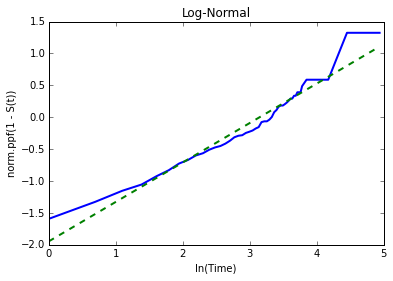

In [144]:
plt.figure()
plt.plot(np.log(kmf.survival_function_.index.values),norm.ppf(1 - kmf.survival_function_['All groups']),linewidth = 2.0)
plt.xlabel('Years')
plt.title('Log-Normal')
plt.ylabel('norm.ppf(1 - S(t))')
plt.xlabel('ln(Time)')
y = norm.ppf(1 - kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)])
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Fit lognormal model to data.


The loglikelihood function for the loglogistic survival model is:

$$ll_{i}=d_{i}\Bigg(log\Bigg(\frac{\phi((log(t)-\mu)\gamma)}{t \gamma^{-1} (1-\Phi(log(t)-\mu)\gamma)}\Bigg)\Bigg)+log(1-\Phi((log(t)-\mu)\gamma)$$

where $\phi$ is the standard normal probabily density function and $\Phi$ is the standard normal cumulative density function.


In [145]:
def _ll_lognormal(y,X,scale,gamma):
    ll = eventvar * (
    np.log(
    norm.pdf(((np.log(y) - scale) * gamma))/
    (y * (1/gamma) * (1 - norm.cdf((np.log(y) - scale) * gamma))))
    ) + np.log(1 - norm.cdf((np.log(y) - scale) * gamma))
    return ll

class Lognormal(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Lognormal, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_lognormal(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Lognormal, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.694366
         Iterations: 66
         Function evaluations: 130
                              Lognormal Results                               
Dep. Variable:                   Time   Log-Likelihood:                -1097.9
Model:                      Lognormal   AIC:                             2198.
Method:            Maximum Likelihood   BIC:                             2202.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:29                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

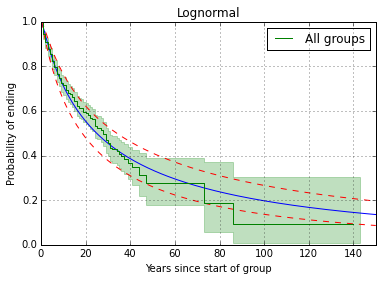

In [146]:
#Log-Normal
start_params_var = [0,0]
lognormal_data = np.repeat(1,len(timevar))
mod_lognormal = Lognormal(timevar,lognormal_data)
res_lognorm = mod_lognormal.fit()
print(res_lognorm.summary())

#Plot the lognormal prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_lognormal.predict_survival_lognormal(res_lognorm.params, t))
plt.plot(t,mod_lognormal.predict_survival_lognormal_cis(res_lognorm.params, res_lognorm.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_lognormal.predict_survival_lognormal_cis(res_lognorm.params, res_lognorm.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Lognormal')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Lognormal.png',dpi = 300)

##Generalized Gamma Survival Model

The density and survival functions for the Generalized gamma are described as:

$$S(t)=\begin{cases}
    1 - I(\gamma,\upsilon),\; \text{if} \;\kappa < 0\\
    1 - \phi(z),\; \text{if} \;\kappa = 0\\
    I(\gamma,\upsilon),\; \text{if} \;\kappa > 0\\
  \end{cases}$$

$$f(t)=\begin{cases}
    \frac{\gamma^{\gamma}}{\sigma t \sqrt{\gamma}\Gamma(\gamma)}e^{z\sqrt{\gamma}-\upsilon},\; \text{if} \;\kappa \neq 0\\
    \frac{1}{\sigma t \sqrt{2\pi}}e^{\frac{-z^{2}}{2}},\; \text{if} \;\kappa = 0\\
  \end{cases}$$

where $\gamma = \frac{1}{|\kappa|^{2}}$ $z=\frac{sign(\kappa)(log(t)-\mu)}{\sigma}$, $\upsilon=\gamma e^{|\kappa|z}$. $I(\gamma,\upsilon)$ is the regularized lower incomplete gamma function:

$$I(\gamma,\upsilon)=\frac{\int_{0}^{\upsilon}e^{-t}t^{\gamma-1}dt}{\Gamma(\gamma)}$$


We can define the log likelihood function separately for different values of $\kappa$ by using the density and survival functions above:

$$ll_{i}=d_{i}log\Bigg(\frac{f_{i}(t)}{S_{i}(t)}\Bigg)+log(S_{i}(t))$$

Generalized Gamma distribution includes Weibull, Exponential and Lognormal distributions as its special cases. More specifically, if $\kappa=1$ it reduces to the Weibull distribution, when $\kappa=1$ and $\sigma=1$ it reduces to the Exponential distribution and if $\kappa=0$, it reduces to the Lognormal distribution. 

In [147]:
def _ll_generalizedgamma(y,X,scale,kappa,sigma):
    gammavalue = np.power(np.abs(kappa),-2)
    zeta = np.sign(kappa) * (np.log(y) - scale) / sigma
    upsilon = gammavalue * np.exp(np.abs(kappa)*zeta)        
    if kappa > 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = 1 - gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa == 0: 
        density = np.exp(- np.power(zeta,2) / 2) / (sigma * y * np.power(2 * np.pi,0.5))
        survival = 1 - norm.cdf(zeta)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa < 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    return ll
    
class Generalizedgamma(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Generalizedgamma, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        kappa = params[1]
        sigma = params[2]
        ll = _ll_generalizedgamma(self.endog,self.exog,scale,kappa,sigma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('kappa')
            self.exog_names.append('sigma')
        if start_params == None:
            start_params = start_params_var 
        return super(Generalizedgamma, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)


Optimization terminated successfully.
         Current function value: 1.693292
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11
                           Generalizedgamma Results                           
Dep. Variable:                   Time   Log-Likelihood:                -1097.3
Model:               Generalizedgamma   AIC:                             2197.
Method:            Maximum Likelihood   BIC:                             2201.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:30                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----

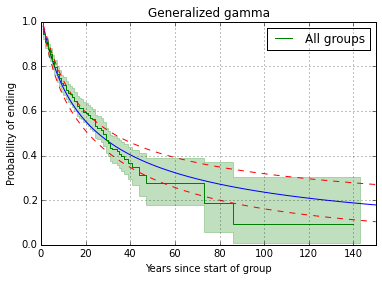

In [148]:
#Generalized gamma
start_params_var = [1,1,1]
generalizedgamma_data = np.repeat(1,len(timevar))
mod_generalizedgamma = Generalizedgamma(timevar,generalizedgamma_data)
res_generalizedgamma = mod_generalizedgamma.fit()
print(res_generalizedgamma.summary())


#Plot the generalized gamma prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(1,150,151)
plt.plot(t,mod_generalizedgamma.predict_survival_generalizedgamma(res_generalizedgamma.params, t))
plt.plot(t,mod_generalizedgamma.predict_survival_generalizedgamma_cis(res_generalizedgamma.params, res_generalizedgamma.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_generalizedgamma.predict_survival_generalizedgamma_cis(res_generalizedgamma.params, res_generalizedgamma.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Generalized gamma')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Generalizedgamma.png',dpi = 300)

Generalized gamma distribution's $\kappa$ parameter is not significant. When $\kappa$ is set to zero, the Generalized Gamma reduces to the Lognormal distribution. 

The AIC and BIC values suggest that the Lognormal survival distribution has the best fit. Although the Generalized Gamma had a slightly lower AIC, the $\kappa$ parameter is not statistically significant, therefore we can conclude that among the distributions we have tried, Lognormal has the best fit to the data.

It is possible to parameterize the scale parameter ($\mu$) in the distributions in terms of variables in the dataset to explore their relationship with the survival outcome. Parameterizations is possible under the proportional hazards or accelerated failure time assumptions. Under the proportional hazards assumption, the coefficients in the model are multiplicative on the hazard, and in an  accelerated failure time coefficients are multiplicative with survival time.

The following table demonstrates how the $\mu$ is parameterized for different distributions under proportional hazards and accelerated failure time assumptions:

|Distribution     |  PH parameterization  |  AFT Parameterization      |
|-----------------|-----------------------|------------------------    |
|Exponential      | $\mu=e^{X^{T}\beta}$  | $\mu=e^{-X^{T}\beta}$      |
|Weibull          | $\mu=e^{X^{T}\beta}$  | $\mu=e^{-X^{T}\beta\gamma}$|
|Gompertz         | $\mu=X^{T}\beta$      |                            |
|Loglogistic      | $\mu=X^{T}\beta$  (Proportional Odds)| $\mu=e^{-X^{T}\beta\gamma}$|
|Lognormal        |                       | $\mu=X^{T}\beta$           |
|Generalized Gamma|                       | $\mu=X^{T}\beta$           |


In [149]:
def _ll_exponentialph(y,X,beta):
    scale = np.exp(np.dot(X,beta))
    ll = eventvar * np.log(scale) - (scale * y)    
    return ll 

class ExponentialPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(ExponentialPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponentialph(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(ExponentialPH, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.663364
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 24
         Hessian evaluations: 12
                            ExponentialPH Results                             
Dep. Variable:                   Time   Log-Likelihood:                -1077.9
Model:                  ExponentialPH   AIC:                             2190.
Method:            Maximum Likelihood   BIC:                             2266.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:34                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

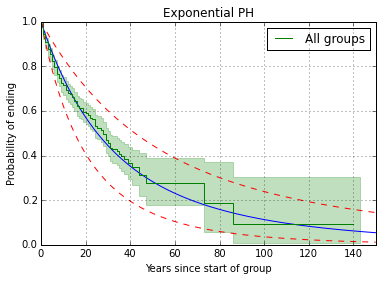

In [150]:
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
#ExponentialPH
start_params_var = np.repeat(0,len(survivaldata.columns))
mod_exponentialph = ExponentialPH(timevar,survivaldata)
res_expPH = mod_exponentialph.fit()
print(res_expPH.summary())

#Plot the exponential PH prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_exponentialph.predict_survival_exponential_ph(res_expPH.params,survivaldata,t))
plt.plot(t,mod_exponentialph.predict_survival_exponential_ph_cis(res_expPH.params,res_expPH.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_exponentialph.predict_survival_exponential_ph_cis(res_expPH.params,res_expPH.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Exponential PH')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('ExponentialPH.png',dpi = 300)

In [151]:
def _ll_weibullph(y,X,beta,gamma):
    scale = np.exp(np.dot(X,beta))
    ll = eventvar * np.log(scale * gamma * np.power(y, (gamma - 1))) - (scale * np.power(y,gamma))
    return ll 
   
class WeibullPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(WeibullPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_weibullph(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(WeibullPH, self).fit(start_params = start_params,method = 'basinhopping',maxiter = maxiter, maxfun = maxfun,**kwds)

basinhopping step 0: f 1.66162
basinhopping step 1: f 1.66162 trial_f 2.96244 accepted 0  lowest_f 1.66162
basinhopping step 2: f 2.11146 trial_f 2.11146 accepted 1  lowest_f 1.66162
basinhopping step 3: f 2.11146 trial_f 2.88275 accepted 0  lowest_f 1.66162
basinhopping step 4: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 5: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 6: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
found new global minimum on step 6 with function value 1.66162
basinhopping step 7: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 8: f 1.66162 trial_f 1.82486 accepted 0  lowest_f 1.66162
basinhopping step 9: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 10: f 1.66162 trial_f 1.90357 accepted 0  lowest_f 1.66162
basinhopping step 11: f 1.8615 trial_f 1.8615 accepted 1  lowest_f 1.66162
basinhopping step 12: f 1.8615 trial_f 4.0902 accepted 0  lowest_f 1.6

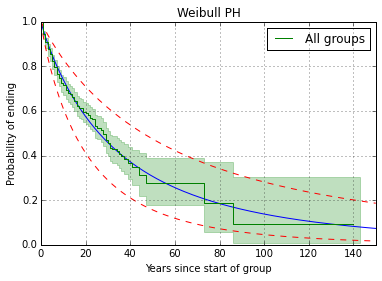

In [152]:
#WeibullPH
#Set the initia gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_weibullph = WeibullPH(timevar,survivaldata)
res_weiPH = mod_weibullph.fit()
print(res_weiPH.summary())

#Plot the weibull PH prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_weibullph.predict_survival_weibull_ph(res_weiPH.params,survivaldata,t))
plt.plot(t,mod_weibullph.predict_survival_weibull_ph_cis(res_weiPH.params,res_weiPH.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_weibullph.predict_survival_weibull_ph_cis(res_weiPH.params,res_weiPH.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Weibull PH')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('WeibullPH.png',dpi = 300)

In [153]:
def _ll_gompertzph(y,X,beta,gamma):
    scale = np.dot(X,beta)
    ll = eventvar * (scale + gamma * y) - ((np.exp(scale) * (np.exp(gamma * y) - 1)) / gamma)    
    return ll
    
class GompertzPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(GompertzPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_gompertzph(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(GompertzPH, self).fit(start_params = start_params,method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.659321
         Iterations: 156
         Function evaluations: 160
         Gradient evaluations: 315
         Hessian evaluations: 156
                              GompertzPH Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1075.2
Model:                     GompertzPH   AIC:                             2184.
Method:            Maximum Likelihood   BIC:                             2261.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:01:39                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf

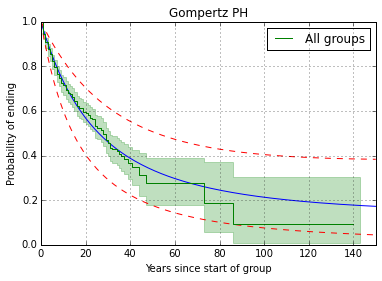

In [154]:
#GompertzPH
start_params_var = np.repeat(0,len(survivaldata.columns))
start_params_var = np.append(start_params_var,1)
mod_gompertzph = GompertzPH(timevar,survivaldata)
res_gompPH = mod_gompertzph.fit()
print(res_gompPH.summary())

#Plot the Gompertz PH prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_gompertzph.predict_survival_gompertz_ph(res_gompPH.params,survivaldata,t))
plt.plot(t,mod_gompertzph.predict_survival_gompertz_ph_cis(res_gompPH.params,res_gompPH.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_gompertzph.predict_survival_gompertz_ph_cis(res_gompPH.params,res_gompPH.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Gompertz PH')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('GompertzPH.png',dpi = 300)

In [155]:
def _ll_loglogisticpo(y,X,beta,gamma):
    scale = np.exp(np.dot(X,beta))
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class LoglogisticPO(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LoglogisticPO, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_loglogisticpo(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LoglogisticPO, self).fit(start_params = start_params, method = 'powell',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.650185
         Iterations: 22
         Function evaluations: 4168
                            LoglogisticPO Results                             
Dep. Variable:                   Time   Log-Likelihood:                -1069.3
Model:                  LoglogisticPO   AIC:                             2173.
Method:            Maximum Likelihood   BIC:                             2249.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:02:12                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------

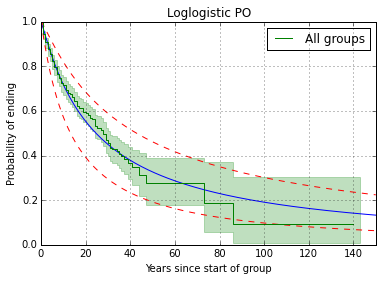

In [156]:
#LoglogisticPO
#Set the initial gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_loglogisticpo = LoglogisticPO(timevar,survivaldata)
res_loglogPO = mod_loglogisticpo.fit()
print(res_loglogPO.summary())

#Plot the loglogistic PO prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_loglogisticpo.predict_survival_loglogistic_po(res_loglogPO.params,survivaldata,t))
plt.plot(t,mod_loglogisticpo.predict_survival_loglogistic_po_cis(res_loglogPO.params,res_loglogPO.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_loglogisticpo.predict_survival_loglogistic_po_cis(res_loglogPO.params,res_loglogPO.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Loglogistic PO')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('LoglogisticPH.png',dpi = 300)

The next section fits the models with the AFT parameterization. We can check the whether the accelerated failure time assumption that the variables are multiplicative on time by plotting the time variable from different groups against each other. Deviations from a straight line indicate that the AFT assumption does not hold. For this plot, we define a function that takes on two arrays with time information as arguments.

In [157]:
def kmqqplot(array1,array2):
    t1 = []
    t2 = []
    foundt1 = False
    foundt2 = False
    current1index = 0
    current2index = 0
    minpercentile = max(float(array1[[0]].min(axis = 0)),float(array2[[0]].min(axis = 0)))
    percentiles = np.linspace(1,minpercentile,11)
    for x in percentiles:
        foundt1 = False
        foundt2 = False
        for y in xrange(current1index,len(array1)):
            if array1.iloc[y,0] <= x and foundt1 == False:            
                current1index = y
                t1.append(array1.index.values[y])
                foundt1 = True
        for g in xrange(current2index,len(array2)):
            if array2.iloc[g,0] <= x and foundt2 == False:
                t2.append(array2.index.values[g])
                current1index = g
                foundt2 = True
    plt.figure()
    minlength = min(len(t1),len(t2))
    plt.scatter(t1[:minlength],t2[:minlength])
    t1_cons = st.add_constant(t1[:minlength],prepend = False)
    linearmodel = st.OLS(t2[:minlength],t1_cons)
    linearmodelresults = linearmodel.fit()
    plt.plot(t1[:minlength],linearmodelresults.fittedvalues,'g')
    plt.xticks(np.arange(0, max(t1[:minlength]) + 5, 4.0))
    plt.yticks(np.arange(0, max(t2[:minlength]) + 5, 4.0))
    plt.xlim(0,max(t1[:minlength]) + 4)
    plt.ylim(0,max(t2[:minlength]) + 4)
    plt.xlabel(array1.columns.values[0])
    plt.ylabel(array2.columns.values[0])

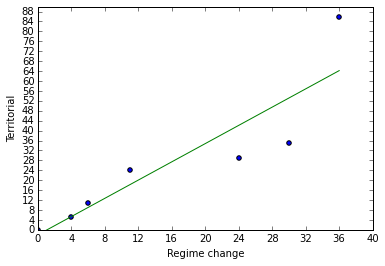

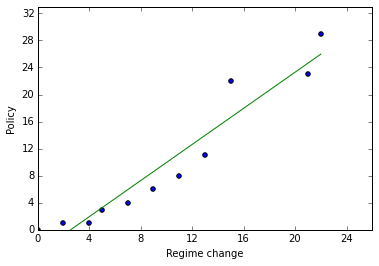

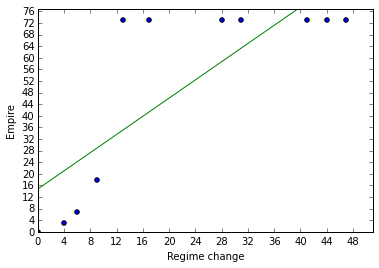

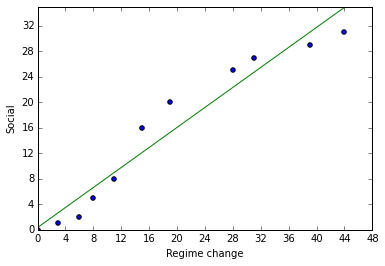

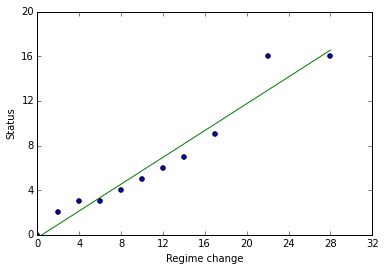

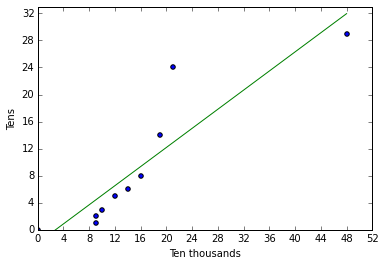

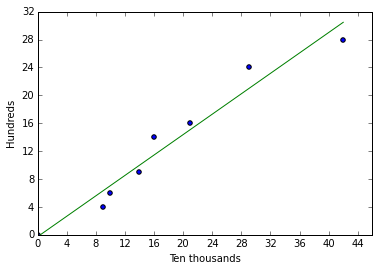

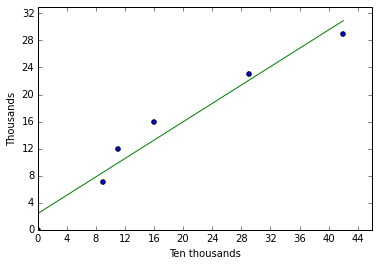

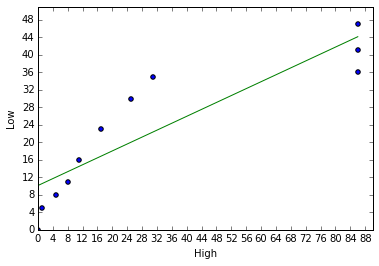

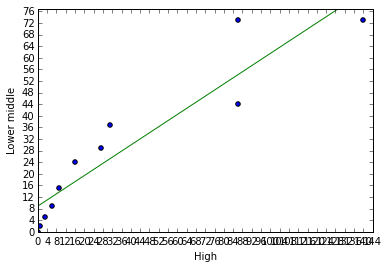

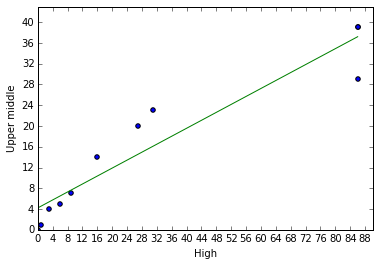

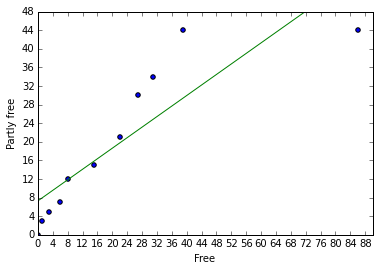

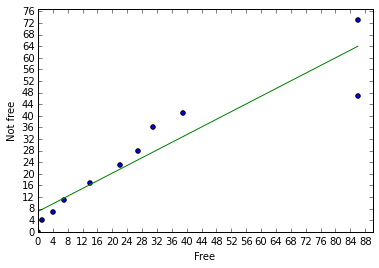

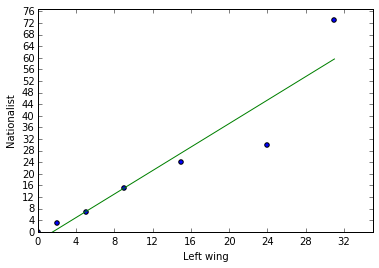

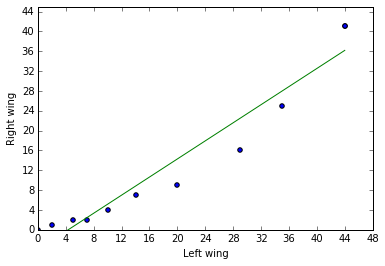

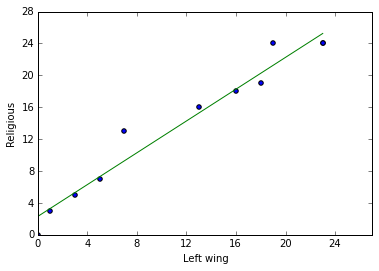

In [158]:
#Fit Kaplan Meier curves for each group, then plot times from different groups against each other
kmf_regime = KaplanMeierFitter()
kmf_regime.fit(timevar[regime],event_observed = eventvar[regime],label = "Regime change")
kmf_territorial = KaplanMeierFitter()
kmf_territorial.fit(timevar[territorial],event_observed = eventvar[territorial],label = "Territorial")
kmf_policy = KaplanMeierFitter()
kmf_policy.fit(timevar[policy],event_observed = eventvar[policy],label = "Policy")
kmf_empire = KaplanMeierFitter()
kmf_empire.fit(timevar[empire],event_observed = eventvar[empire],label = "Empire")
kmf_social = KaplanMeierFitter()
kmf_social.fit(timevar[social],event_observed = eventvar[social],label = "Social")
kmf_status = KaplanMeierFitter()
kmf_status.fit(timevar[status],event_observed = eventvar[status],label = "Status")

kmqqplot(kmf_regime.survival_function_,kmf_territorial.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_policy.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_empire.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_social.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_status.survival_function_)

kmf_tenthousands = KaplanMeierFitter()
kmf_tenthousands.fit(timevar[tenthousands],event_observed = eventvar[tenthousands],label = "Ten thousands")
kmf_tens = KaplanMeierFitter()
kmf_tens.fit(timevar[tens],event_observed = eventvar[tens],label = "Tens")
kmf_hundreds = KaplanMeierFitter()
kmf_hundreds.fit(timevar[hundreds],event_observed = eventvar[hundreds],label = "Hundreds")
kmf_thousands = KaplanMeierFitter()
kmf_thousands.fit(timevar[thousands],event_observed = eventvar[thousands],label = "Thousands")

kmqqplot(kmf_tenthousands.survival_function_,kmf_tens.survival_function_)
kmqqplot(kmf_tenthousands.survival_function_,kmf_hundreds.survival_function_)
kmqqplot(kmf_tenthousands.survival_function_,kmf_thousands.survival_function_)

kmf_low = KaplanMeierFitter()
kmf_low.fit(timevar[low],event_observed = eventvar[low],label = "Low")
kmf_lowermiddle = KaplanMeierFitter()
kmf_lowermiddle.fit(timevar[lowermiddle],event_observed = eventvar[lowermiddle],label = "Lower middle")
kmf_uppermiddle = KaplanMeierFitter()
kmf_uppermiddle.fit(timevar[uppermiddle],event_observed = eventvar[uppermiddle],label = "Upper middle")
kmf_high = KaplanMeierFitter()
kmf_high.fit(timevar[high],event_observed = eventvar[high],label = "High")

kmqqplot(kmf_high.survival_function_,kmf_low.survival_function_)
kmqqplot(kmf_high.survival_function_,kmf_lowermiddle.survival_function_)
kmqqplot(kmf_high.survival_function_,kmf_uppermiddle.survival_function_)

kmf_free = KaplanMeierFitter()
kmf_free.fit(timevar[free],event_observed = eventvar[free],label = "Free")
kmf_partlyfree = KaplanMeierFitter()
kmf_partlyfree.fit(timevar[partlyfree],event_observed = eventvar[partlyfree],label = "Partly free")
kmf_notfree = KaplanMeierFitter()
kmf_notfree.fit(timevar[notfree],event_observed = eventvar[notfree],label = "Not free")

kmqqplot(kmf_free.survival_function_,kmf_partlyfree.survival_function_)
kmqqplot(kmf_free.survival_function_,kmf_notfree.survival_function_)

kmf_left_wing = KaplanMeierFitter()
kmf_left_wing.fit(timevar[left_wing],event_observed = eventvar[left_wing],label = "Left wing")
kmf_nationalist = KaplanMeierFitter()
kmf_nationalist.fit(timevar[nationalist],event_observed = eventvar[nationalist],label = "Nationalist")
kmf_right_wing = KaplanMeierFitter()
kmf_right_wing.fit(timevar[right_wing],event_observed = eventvar[right_wing],label = "Right wing")
kmf_religious = KaplanMeierFitter()
kmf_religious.fit(timevar[religious],event_observed = eventvar[religious],label = "Religious")

kmqqplot(kmf_left_wing.survival_function_,kmf_nationalist.survival_function_)
kmqqplot(kmf_left_wing.survival_function_,kmf_right_wing.survival_function_)
kmqqplot(kmf_left_wing.survival_function_,kmf_religious.survival_function_)   

Except for groups that seek to found an empire, there are no major deviations from the AFT assumption.

The next section shows the implementation of the AFT parameterization with different survival models.

In [159]:
def _ll_exponentialaft(y,X,beta):
    scale = np.exp(-np.dot(X,beta))
    ll = eventvar * np.log(scale) - (scale * y)    
    return ll 

class ExponentialAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(ExponentialAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponentialaft(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(ExponentialAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.663364
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 24
         Hessian evaluations: 12
                            ExponentialAFT Results                            
Dep. Variable:                   Time   Log-Likelihood:                -1077.9
Model:                 ExponentialAFT   AIC:                             2190.
Method:            Maximum Likelihood   BIC:                             2266.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:02:51                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

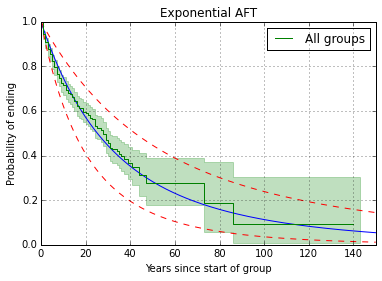

In [160]:
#ExponentialAFT
start_params_var = np.repeat(0,len(survivaldata.columns))
mod_exponentialaft = ExponentialAFT(timevar,survivaldata)
res_expAFT = mod_exponentialaft.fit()
print(res_expAFT.summary())

#Plot the exponential AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_exponentialaft.predict_survival_exponential_aft(res_expAFT.params,survivaldata,t))
plt.plot(t,mod_exponentialaft.predict_survival_exponential_aft_cis(res_expAFT.params,res_expAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_exponentialaft.predict_survival_exponential_aft_cis(res_expAFT.params,res_expAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Exponential AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('ExponentialAFT.png',dpi = 300)

In [161]:
def _ll_weibullaft(y,X,beta,gamma):
    scale = np.exp(-1 * np.dot(X,beta) * gamma)
    ll = eventvar * np.log(scale * gamma * np.power(y, (gamma - 1))) - (scale * np.power(y,gamma))
    return ll 
   
class WeibullAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(WeibullAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_weibullaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(WeibullAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.661621
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 24
         Hessian evaluations: 11
                              WeibullAFT Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1076.7
Model:                     WeibullAFT   AIC:                             2187.
Method:            Maximum Likelihood   BIC:                             2264.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:03:23                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

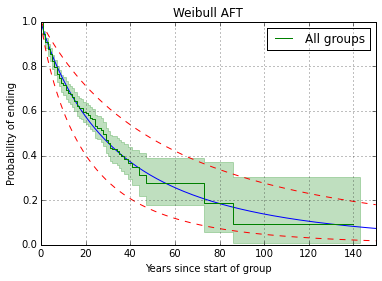

In [162]:
#WeibullAFT
#Set the initial gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_weibullaft = WeibullAFT(timevar,survivaldata)
res_weiAFT = mod_weibullaft.fit()
print(res_weiAFT.summary())

#Plot the weibull AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_weibullaft.predict_survival_weibull_aft(res_weiAFT.params,survivaldata,t))
plt.plot(t,mod_weibullaft.predict_survival_weibull_aft_cis(res_weiAFT.params,res_weiAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_weibullaft.predict_survival_weibull_aft_cis(res_weiAFT.params,res_weiAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Weibull AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('WeibullAFT.png',dpi = 300)

In [163]:
def _ll_loglogisticaft(y,X,beta,gamma):
    scale = np.exp(- np.dot(X,beta) * gamma)
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class LoglogisticAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LoglogisticAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_loglogisticaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LoglogisticAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.650116
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 21
         Hessian evaluations: 10
                            LoglogisticAFT Results                            
Dep. Variable:                   Time   Log-Likelihood:                -1069.3
Model:                 LoglogisticAFT   AIC:                             2173.
Method:            Maximum Likelihood   BIC:                             2249.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:03:58                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

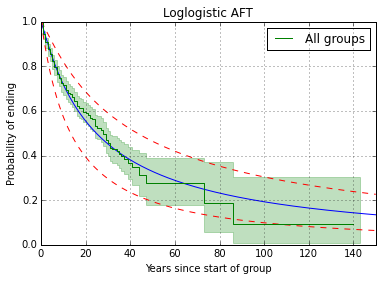

In [164]:
#LoglogisticAFT
#Set the initia gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_loglogisticaft = LoglogisticAFT(timevar,survivaldata)
res_loglogAFT = mod_loglogisticaft.fit()
print(res_loglogAFT.summary())

#Plot the loglogistic AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_loglogisticaft.predict_survival_loglogistic_aft(res_loglogAFT.params,survivaldata,t))
plt.plot(t,mod_loglogisticaft.predict_survival_loglogistic_aft_cis(res_loglogAFT.params,res_loglogAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_loglogisticaft.predict_survival_loglogistic_aft_cis(res_loglogAFT.params,res_loglogAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Loglogistic AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('LoglogisticAFT.png',dpi = 300)

In [165]:
def _ll_lognormalaft(y,X,beta,gamma):
    scale = np.dot(X,beta)
    ll = eventvar * (
    np.log(
    norm.pdf(((np.log(y) - scale) * gamma))/
    (y * (1/gamma) * (1 - norm.cdf((np.log(y) - scale) * gamma))))
    ) + np.log(1 - norm.cdf((np.log(y) - scale) * gamma))
    return ll

class LognormalAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LognormalAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_lognormalaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LognormalAFT, self).fit(start_params = start_params,method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.640467
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 25
         Hessian evaluations: 12
                             LognormalAFT Results                             
Dep. Variable:                   Time   Log-Likelihood:                -1063.0
Model:                   LognormalAFT   AIC:                             2160.
Method:            Maximum Likelihood   BIC:                             2236.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:04:37                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

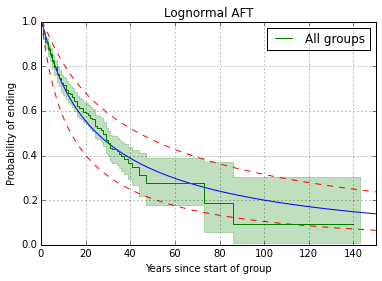

In [166]:
#LognormalAFT
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_lognormalaft = LognormalAFT(timevar,survivaldata)
res_lognormAFT = mod_lognormalaft.fit()
print(res_lognormAFT.summary())


#Plot the lognormal AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_lognormalaft.predict_survival_lognormal_aft(res_lognormAFT.params,survivaldata,t))
plt.plot(t,mod_lognormalaft.predict_survival_lognormal_aft_cis(res_lognormAFT.params,res_lognormAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_lognormalaft.predict_survival_lognormal_aft_cis(res_lognormAFT.params,res_lognormAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Lognormal AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('LognormalAFT.png',dpi = 300)

In [167]:
def _ll_generalizedgammaaft(y,X,beta,kappa,sigma):
    scale = np.dot(X,beta)
    gammavalue = np.power(np.abs(kappa),-2)
    zeta = np.sign(kappa) * (np.log(y) - scale) / sigma
    upsilon = gammavalue * np.exp(np.abs(kappa)*zeta)        
    if kappa > 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = 1 - gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa == 0: 
        density = np.exp(- np.power(zeta,2) / 2) / (sigma * y * np.power(2 * np.pi,0.5))
        survival = 1 - norm.cdf(zeta)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa < 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    return ll
    
class GeneralizedgammaAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(GeneralizedgammaAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        beta = params[:-2]
        kappa = params[-2]
        sigma = params[-1]
        ll = _ll_generalizedgammaaft(self.endog,self.exog,beta,kappa,sigma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('kappa')
            self.exog_names.append('sigma')
        if start_params == None:
            start_params = start_params_var 
        return super(GeneralizedgammaAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.632725
         Iterations: 13
         Function evaluations: 21
         Gradient evaluations: 32
         Hessian evaluations: 13
                          GeneralizedgammaAFT Results                          
Dep. Variable:                    Time   Log-Likelihood:                -1058.0
Model:             GeneralizedgammaAFT   AIC:                             2150.
Method:             Maximum Likelihood   BIC:                             2226.
Date:                 Sat, 14 Nov 2015                                         
Time:                         19:06:12                                         
No. Observations:                  648                                         
Df Residuals:                      631                                         
Df Model:                           16                                         
                          coef    std err          z      P>|z|      [95.0%

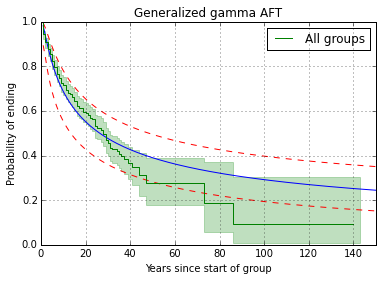

In [168]:
#Generalized gamma AFT
start_params_var = np.repeat(1,len(survivaldata.columns) + 2)
mod_generalizedgammaaft = GeneralizedgammaAFT(timevar,survivaldata)
res_generalizedgammaAFT = mod_generalizedgammaaft.fit()
print(res_generalizedgammaAFT.summary())
#Plot the generalized gamma aft prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(1,150,150)
plt.plot(t,mod_generalizedgammaaft.predict_survival_generalizedgamma_aft(res_generalizedgammaAFT.params, survivaldata, t))
plt.plot(t,mod_generalizedgammaaft.predict_survival_generalizedgamma_aft_cis(res_generalizedgammaAFT.params, res_generalizedgammaAFT.cov_params(), survivaldata, t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_generalizedgammaaft.predict_survival_generalizedgamma_aft_cis(res_generalizedgammaAFT.params, res_generalizedgammaAFT.cov_params(), survivaldata, t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Generalized gamma AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('GeneralizedgammaAFT.png',dpi = 300)

Results from the models with AFT and PH assumptions are summarized in the table below. Groups that seek territorial change last longer under the AFT assumption and their hazard of ending at any time is lower under the PH assumptio compared to groups that seek regime change. Religious groups last longer under the AFT assumption and their hazard of ending at any time is lower under the PH assumptio compared to left wing groups. Loglogistic, lognormal and Generalized Gamma AFT models suggest that right wing groups end earlier compared to left wing groups and the loglogistic PO model suggests that the odds of ending are higher for right wing groups compared to left wing groups. None of the PH models found a relationship between the operating peak size of the group and hazard of ending. Loglogistic, lognormal and Generalized gamma AFT models suggest that groups with less than 100 members, end earlier compared to groups whose peak operating size is in the ten thousands. Interestingly, none of the models suggest that the freedom index level and income level of the country against which the terrorist groups are operating is associated with a different survival duration.

####Results (coefficient, [p-value], $* p<0.05$, $** p<0.01$)
|Variable	|Exponential AFT	|Weibull AFT	|Loglogistic AFT	|Lognormal AFT	|Ggamma AFT	|Exponential PH	|Weibull PH	|Gompertz PH	|Loglogistic PO|
|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------|
|Territorial change	| 0.648 [0.004]**	| 0.696 [0.005]**	| 0.756 [0.002]**	| 0.790 [0.001]**	| 0.752 [0.001]**	| -0.646 [0.004]**	| -0.645 [0.004]**	| -0.641 [0.004]**	| -0.849 [0.003]**|
|Policy change	| 0.227 [0.24]	| 0.235 [0.259]	| 0.15 [0.494]	| 0.137 [0.525]	| -0.053 [0.8]	| -0.227 [0.24]	| -0.217 [0.259]	| -0.211 [0.274]	| -0.164 [0.516]|
|Empire	| 0.088 [0.846]	| 0.071 [0.886]	| -0.055 [0.914]	| -0.149 [0.751]	| -0.360 [0.373]	| -0.088 [0.846]	| -0.065 [0.886]	| -0.012 [0.979]	| 0.138 [0.814]|
|Social revolution	| 0.06 [0.803]	| 0.065 [0.8]	| 0.006 [0.983]	| 0.007 [0.978]	| -0.122 [0.642]	| -0.06 [0.803]	| -0.060 [0.8]	| -0.04 [0.866]	| -0.022 [0.945]|
|Status Quo	| 0.189 [0.58]	| 0.206 [0.573]	| 0.176 [0.664]	| 0.241 [0.545]	| 0.25 [0.506]	| -0.188 [0.58]	| -0.191 [0.573]	| -0.220 [0.517]	| -0.191 [0.681]|
|1,000s	| 0.265 [0.392]	| 0.265 [0.427]	| 0.130 [0.714]	| 0.119 [0.756]	| 0.003 [0.993]	| -0.265 [0.392]	| -0.245 [0.428]	| -0.194 [0.529]	| -0.144 [0.725]|
|100s	| -0.349 [0.22]	| -0.351 [0.253]	| -0.495 [0.135]	| -0.506 [0.153]	| -0.704 [0.045]**	| 0.349 [0.22]	| 0.325 [0.253]	| 0.302 [0.287]	| 0.55 [0.152]|
|10s	| -0.38 [0.181]	| -0.361 [0.239]	| -0.651 [0.049]**	| -0.735 [0.035]**	| -1.237 [0.001]**	| 0.38 [0.181]	| 0.334 [0.241]	| 0.297 [0.297]	| 0.765 [0.047]|
|Low income	| -0.136 [0.584]	| -0.120 [0.654]	| -0.052 [0.852]	| -0.044 [0.873]	| -0.034 [0.895]	| 0.136 [0.584]	| 0.111 [0.654]	| 0.077 [0.757]	| 0.04 [0.902]|
|Lower middle income	| 0.033 [0.884]	| 0.047 [0.85]	| 0.053 [0.844]	| 0.025 [0.924]	| -0.045 [0.855]	| -0.033 [0.884]	| -0.043 [0.85]	| -0.054 [0.81]	| -0.096 [0.754]|
|Upper middle income	| -0.242 [0.308]	| -0.243 [0.343]	| -0.197 [0.468]	| -0.196 [0.465]	| -0.023 [0.927]	| 0.242 [0.308]	| 0.225 [0.344]	| 0.209 [0.377]	| 0.208 [0.505]|
|Partly free	| 0.068 [0.728]	| 0.081 [0.701]	| 0.103 [0.645]	| 0.111 [0.619]	| 0.107 [0.605]	| -0.068 [0.728]	| -0.075 [0.701]	| -0.082 [0.673]	| -0.098 [0.704]|
|Free	| 0.152 [0.491]	| 0.169 [0.48]	| 0.215 [0.393]	| 0.169 [0.503]	| 0.077 [0.745]	| -0.152 [0.491]	| -0.156 [0.479]	| -0.162 [0.464]	| -0.248 [0.393]|
|Nationalist	| 0.095 [0.616]	| 0.096 [0.639]	| 0.018 [0.934]	| -0.061 [0.78]	| -0.287 [0.193]	| -0.095 [0.616]	| -0.089 [0.639]	| -0.079 [0.676]	| -0.015 [0.953]|
|Religious	| 1.137 [0]**	| 1.240 [0]**	| 1.171 [0]**	| 1.104 [0]**	| 0.812 [0.001]**	| -1.137 [0]**	| -1.148 [0]**	| -1.153 [0]**	| -1.350 [0]**|
|Right wing	| -0.371 [0.135]	| -0.408 [0.127]	| -0.759 [0.012]*	| -0.719 [0.014]*	| -0.752 [0.01]*	| 0.371 [0.135]	| 0.378 [0.126]	| 0.435 [0.078]	| 0.882 [0.012]*|



The next section describes how the confidence intervals are calculated for the survival predictions.

##5) Constructing Confidence Intervals

Since $S(t)$ is defined between $[0,\,1]$, building the confidence intervals around the survival prediction itself can yield intervals that are smaller than 0 or greater than 1. Therefore the confidence interval is constructed around the transformed survival prediction. This is the log-log transformation. Taking the log of the survival function, the range changes to $(-\inf,\,0)$, taking the negative changes the range to $[0,\,\inf)$ and taking the log again changes the range to $(-\inf,\,\inf)$. When we construct the confidence interval around this transformation, transforming the interval back to the original scale will always yield a confidence interval within $[0,\,1]$.

We need the standard error of this transformed survival prediction to calculate the upper and lower bounds. We can use the properties of the variances and multivariate first order Taylor series expansion to calculate the variance of the log-log transformation:   

$$var(aX\,+\,bY)\,=\,a^{2}var(X)\,+\,b^{2}var(Y)$$ 

$$var(X+a)\,=\,var(X)$$ 

where $a$ and $b$ are constants. 

Taylor series of a function $z(x,y)$ around a point $(x_0,y_0)$ provides an approximation of the function around $(x_0,y_0)$:

$$ z(x_0\,+\varepsilon\,,\,y_0\,+\delta)=z(x_0,y_0)+\frac{dz}{dx}|_{(x_0,y_0)}\varepsilon+\frac{dz}{dy}|_{(x_0,y_0)}\delta$$

where $\frac{dz}{dx}|_{(x_0,y_0)}$ is the derivative of the function with respect to $x_0$ evaluated at the values of $x_0$ and $y_0$, the values around which we build the approximation, in our case, these are the survival model parameter estimates.

In order to get the variance of $log(-log(S(t,\theta)))$ we first write its first order Taylor approximation around the estimate of $\theta$ (in this section, we include $\theta$ inside the survival function to emphasize that the prediction is a function of the paramters that will be estimated from the model. We drop the $\theta$ in the remaining of the notebook):

$$log(-log(S(t,\theta))) \approx log(-log(S(t,\hat{\theta})))+\frac{d(log(-log(S(t,\theta))))}{d\theta}(\theta-\hat{\theta}) $$

where $\theta$ is the coefficient and $\hat{\theta}$ is the maximum likelihood mean estimate of $\beta$ and is treated as a constant.  

$$var(log(-log(S(t,\theta)))) \approx var(log(-log(S(t,\hat{\theta})))+\frac{d(log(-log(S(t,\theta))))}{d\theta}(\beta-\hat{\theta}))$$

$var(log(-log(S(t,\theta)))) \approx var(log(-log(S(t,\hat{\theta}))))+var\Bigg(\frac{d(log(-log(S(t,\theta))))}{d\theta}(\theta-\hat{\theta})\Bigg) $

$var(log(-log(S(t,\theta)))) \approx var(log(-log(S(t,\hat{\theta}))))-var\Bigg(\frac{d(log(-log(S(t,\theta))))}{d\theta}\hat{\theta}\Bigg)+var\Bigg(\frac{d(log(-log(S(t,\theta))))}{d\theta}\theta\Bigg)$


Because $log(-log(S(t,\hat{\theta})))$ and $\frac{d(log(-log(S(t,\theta))))}{d\theta}\hat{\theta}$ are constants, their variance is zero. That leaves us with $var\big(\frac{d(log(-log(S(t,\theta))))}{d\theta}\theta\big)$. Since $var(\bf{c}X)=\bf{c^{T}}var(X)\bf{c}$ where $\bf{c}$ is a vector, we finally can write the variance of the log-log of the survival prediction as:

$$\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]^{T}\sum\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]$$

where $\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]$ is the vector of derivatives of the transformed survival prediction with respect to each of the model parameters and $\sum$ is the variance-covariance matrix of the parameters. $\sum$ equals to the negative inverse Hessian (the second derivative) of the loglikelihood function, evaluated at the values of $\theta$ (Some optimization methods calculate an approximation to the second derivative of the loglikelihood function, rather than calculating the second derivative itself). For a review of the likelihood theory, please see appendix 1 in the Generalized Likelihood Models lecture notes:
http://data.princeton.edu/wws509/notes/a1.pdf

This method of using the first order Taylor series approximation to calcualte the variance of a function is called the delta method (for a description of the delta method, see Stata documentation: http://www.stata.com/support/faqs/statistics/delta-method/)

Once we have the variance of the log-log survival function, we can use it to calculate the confidence interval as:

$$P\Big(S(t,\hat{\theta})^{e^{-1.96\sqrt{\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]^{T}\sum\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]}}} < S(t,\theta) < S(t,\hat{\theta})^{e^{1.96\sqrt{\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]^{T}\sum\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]}}}\Big)=0.95$$

As an example, we can calculte the confidence interval for the Exponential survival model:

$$var(log(-log(S(t))))$$

$$=var(log(-log(e^{-e^{-X\beta}t})))$$

$$=var(-X\beta)$$

Using $(1)$, treating $X$ as a constant, we can find the variance as:

$$var(-X\beta)={\bf{X^{T}} \sum \bf{X}}$$

where $\sum$ is the variance-covariance matrix of the coefficient vector $\bf{\beta}$.

After we find the variance of the log-log transformed survival probability, the 95% confidence intervals are given by:

$$[S(t)^{e^{1.96 \sqrt{\bf{X^{T}} \sum \bf{X}}}}\;,\;S(t)^{e^{-1.96 \sqrt{\bf{X^{T}} \sum \bf{X}}}}]$$

Another example is the confidence interval for the Generalized Gamma distribtion:

As usual, we take the derivative of the $log(-log(S(t)))$ with respect to all model parameters, in this case $\mu$, $\kappa$ and $\sigma$. Note that in the following equations, $\gamma = \frac{1}{|\kappa|^{2}}$ and $\upsilon=\gamma|\kappa|sign(\kappa)e^{\frac{log(t)-\mu}{\sigma}}$

For $\kappa<0$ we have $S(t)=1-I(\gamma,\upsilon)$ where $I(\gamma,\upsilon)$ is the regularized lower incomplete gamma function, which in turn equals to 1 minus the regularized upper incomplete gamma function: $I(\gamma,\upsilon)=1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)}$


Derivative of $log(-log(1 - I(\gamma,\upsilon)))$ with respect to $\mu$:

$$\frac{dlog(-log(S(t)))}{d\mu}=\frac{-|\kappa|sign(\kappa)\upsilon^{\gamma - 1}e^{\frac{(|\kappa|sign(\kappa)(log(t) - \mu)}{\sigma} - \upsilon}}{\kappa^{2}\sigma\Gamma(\gamma)(1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)})log(1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)})}  $$

Derivative of $log(-log(1 - I(\gamma,\upsilon)))$ with respect to $\kappa$, $\frac{dlog(-log(S(t)))}{d\kappa}=$:


$$\frac{\frac{-1}{\Gamma(\gamma)}\Bigg(\Bigg(\frac{-2}{\kappa^{3}}\Big( G_{2,3}^{3,0}\Bigg(\upsilon \Big|\begin{pmatrix}1,1\\0,0,\gamma\\ \end{pmatrix}\Bigg)+log(\upsilon)\Gamma(\gamma,\upsilon)\Big)\Bigg)-e^{-\upsilon}\upsilon^{\gamma - 1}\Big(\upsilon\big( (\frac{2|\kappa|\delta(\kappa)(log(t)-\mu)}{\sigma})+(\frac{\kappa sign(\kappa)(log(t)-\mu)}{\sigma|\kappa|})\big) - (\frac{2e^{\frac{|\kappa|sign(\kappa)(log(t)-\mu)}{\sigma}}}{\kappa^{3}})\Big)\Bigg)-\frac{(2\psi(\gamma)\Gamma(\gamma,\upsilon)}{\kappa^{3}\Gamma(\gamma)}}{(1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)})log(1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)})}$$


In the derivative above, $G_{2,3}^{3,0}\Bigg(\upsilon \Big|\begin{pmatrix}1,1\\0,0,\gamma\\ \end{pmatrix}\Bigg)$ is the meijer G function, which is a general function used to express different special functions (see Wolfram Mathworld http://mathworld.wolfram.com/MeijerG-Function.html and wikipedia entry on the meijer g function https://en.wikipedia.org/wiki/Meijer_G-function). We use Python package mpmath's meijer g function to calculate its value. For more information on meijer G function in mpmath, please see mpmath documentation on the meijer g function: http://mpmath.org/doc/current/functions/hypergeometric.html?highlight=meijer. Here is a stackoverflow question that can be helpful to understand how to use the meijer g in mpmath: http://stackoverflow.com/questions/31424907/mpmath-meijerg-order-of-arguments

The expression $\delta(x)$ is the Dirac delta function, which takes the value 0 for all values of $x$ except when $x=1$ when it goes to positive infinity. It is the derivative of the sign function $sign(x)$ which takes the value 1 if its argument is positive, -1 if its argument is negative and 0 if its argument is zero. See the wikipedia entry on Dirac delta function for more details https://en.wikipedia.org/wiki/Dirac_delta_function.

Derivative of $log(-log(1 - I(\gamma,\upsilon)))$ with respect to $\sigma$:

$$\frac{dlog(-log(S(t)))}{d\sigma}= \frac{-|\kappa|sign(\kappa)\frac{log(t)-\mu}{\mu}\upsilon^{\gamma-1}e^{( |\kappa|sign(\kappa)\frac{log(t)-\mu}{\sigma}     -\upsilon) }                                   }                    {\kappa^{2}\sigma^{2}\Gamma(\gamma)(1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)})log(1-\frac{\Gamma(\gamma,\upsilon)}{\Gamma(\gamma)})                          }                                    $$


Once we have the derivatives, the variance of $log(-log(S(t)))$ is calculated the regular way:

$$var(log(-log(S(t)))) \approx  
\begin{bmatrix}
\frac{dlog(-log(S(t)))}{d\mu}\\
\frac{dlog(-log(S(t)))}{d\kappa}\\
\frac{dlog(-log(S(t)))}{d\sigma}\\
\end{bmatrix}^{'}
\sum
\begin{bmatrix}
\frac{dlog(-log(S(t)))}{d\mu}\\
\frac{dlog(-log(S(t)))}{d\kappa}\\
\frac{dlog(-log(S(t)))}{d\sigma}\\
\end{bmatrix}
$$

Where $\sum$ is the variance-covariance matrix of model parameters. We can use this to construct a confidence interval around the survival prediction in the usual way:

$$S(t)^{e^{1.96\sqrt{var(log(-log(S(t))))}}},S(t)^{e^{-1.96\sqrt{var(log(-log(S(t))))}}}$$

The confidence intervals for the remaining survival predictions are calculated in the same way.

1) Transform the survival prediction: $log(-log(S(t)))$

2) Find the vector of derivatives of $log(-log(S(t)))$ with respect to each of the parameters.

3) Now we have, using the first order Taylor series approximation of $log(-log(S(t)))$): 

$$var(log(-log(S(t))))=\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]^{T}\sum\Big[\frac{d(log(-log(S(t,\theta))))}{d\theta}\Big]$$ 

4) Use the expression in 3 to calculate the confidence interval around $log(-log(S(t)))$: 

$$ P\big(log(-log(S(t)))1.96\sqrt{var(log(-log(S(t))))}< log(-log(S(t)))< log(-log(S(t)))-1.96\sqrt{var(log(-log(S(t))))}\big)=0.95$$

5) Then transform the expression in 4 back to the original scale:

$$ P\big(e^{-e^{log(-log(S(t)))1.96\sqrt{var(log(-log(S(t))))}}} < e^{-e^{log(-log(S(t)))}} < e^{-e^{log(-log(S(t)))-1.96\sqrt{var(log(-log(S(t))))}\big)}}=0.95$$

$$P\big(S(t)^{1.96 \sqrt{var(log(-log(S(t))))}}< S(t) < S(t)^{-1.96 \sqrt{var(log(-log(S(t))))}}\big)=0.95$$

In [169]:
    #The following is added to the prediction class in Model.py(object):    
    def predict_survival_exponential_aft(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        XB = np.dot(X,params)
        for time in timerange:
            predicted_survival_units.append(np.exp(-np.exp(-XB) * time))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival
    
    def predict_survival_exponential_aft_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for unit in range(len(X)):
                covariates = list(X.iloc[unit])
                XB = np.dot(covariates,params)
                sqrt = np.sqrt(np.dot(np.dot(covariates,covar),covariates))
                lower = np.power(np.exp(-np.exp(-XB) * time),np.exp( 1.96 * sqrt))
                lower_bound.append(lower)
                upper = np.power(np.exp(-np.exp(-XB) * time),np.exp(-1.96 * sqrt))         
                upper_bound.append(upper)
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame    

In [170]:
    def predict_survival_weibull_aft(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        XBg = np.dot(X,params[:-1]) * params[-1]
        for time in timerange:
            predicted_survival_units.append(np.exp(-np.exp(-XBg) * np.power(time,params[-1])))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival
    
    def predict_survival_weibull_aft_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        gamma = params[-1]
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for patient in range(len(X)):
                covariates = list(X.iloc[patient])
                XB = np.dot(covariates,params[0:(len(params) - 1)])                
                Xgamma = np.dot(covariates,gamma)                
                derivativevector = np.append(Xgamma,np.log(np.maximum(1,time)) - XB)
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(np.exp(-np.exp(-XB * gamma) * np.power(time,gamma)),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(np.exp(-np.exp(-XB * gamma) * np.power(time,gamma)),np.exp(-1.96 * sqrt)))
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame


    def predict_survival_loglogistic_aft(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        gamma = params[-1]
        beta = params[0:(len(params) - 1)]
        XBg = np.dot(X,beta) * gamma
        for time in timerange:
            predicted_survival_units.append(1/(1 + (np.exp(-XBg) * np.power(time,gamma))))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival

    def predict_survival_loglogistic_aft_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        gamma = params[-1]
        beta = params[0:(len(params) - 1)]
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for patient in range(len(X)):
                covariates = list(X.iloc[patient])
                Xgamma = np.dot(covariates,gamma)
                XB = np.dot(covariates,beta)
                XBg = XB * gamma
                tg = np.power(time,gamma)
                multiplierbetas = (
                (tg*np.exp(-XBg))/
                (np.log(1+np.exp(-XBg)*tg)*(1+np.exp(-XBg)*tg))
                )
                Xmultipliers = np.dot(-Xgamma,multiplierbetas)
                multipliergamma = (
                (tg*np.exp(-XBg)) * (np.log(time)-XB) /                
                (np.log(1+np.exp(-XBg)*tg)*(1+np.exp(-XBg)*tg))                
                )
                derivativevector = np.append(Xmultipliers,multipliergamma)
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(1/(1 + (np.exp(-XBg) * np.power(time,gamma))),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(1/(1 + (np.exp(-XBg) * np.power(time,gamma))),np.exp(-1.96 * sqrt)))
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame

    def predict_survival_lognormal_aft(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        gamma = params[-1]
        beta = params[0:(len(params) - 1)]
        XB = np.dot(X,beta)
        for time in timerange:
            predicted_survival_units.append(1 - norm.cdf((np.log(time) - XB) * gamma))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival

    def predict_survival_lognormal_aft_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        gamma = params[-1]
        beta = params[0:(len(params) - 1)]
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for patient in range(len(X)):
                covariates = list(X.iloc[patient])
                Xgamma = np.dot(covariates,gamma)
                XB = np.dot(covariates,beta)
                normalargument = (np.log(time) - XB) * gamma
                multiplier = (
                norm.pdf(normalargument)/                
                (np.log(1 - norm.cdf(normalargument))*(1-norm.cdf(normalargument)))
                )
                multiplierbetas = np.dot(-Xgamma, multiplier) 
                multipliergamma = np.dot((np.log(time) - XB), multiplier) 
                derivativevector = np.append(multiplierbetas,multipliergamma)
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(1 - norm.cdf(normalargument),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(1 - norm.cdf(normalargument),np.exp(-1.96 * sqrt)))
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame

    def predict_survival_generalizedgamma_aft(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        scale = np.dot(X,params[:-2])
        kappa = params[-2]
        sigma = params[-1]
        gamma = np.power(np.abs(kappa),-2)
        if kappa > 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                predicted_survival_units.append(1 - gammainc(gamma,upsilon))
        if kappa == 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                predicted_survival_units.append(1 - norm.cdf(zeta))
        if kappa < 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                predicted_survival_units.append(gammainc(gamma,upsilon))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival    
    
    
    def predict_survival_generalizedgamma_aft(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        scale = np.dot(X,params[:-2])
        kappa = params[-2]
        sigma = params[-1]
        gamma = np.power(np.abs(kappa),-2)
        if kappa > 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                predicted_survival_units.append(1 - gammainc(gamma,upsilon))
        if kappa == 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                predicted_survival_units.append(1 - norm.cdf(zeta))
        if kappa < 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                predicted_survival_units.append(gammainc(gamma,upsilon))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival    
   
    def predict_survival_generalizedgamma_aft_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        beta = params[:-2]
        kappa = params[-2]
        sigma = params[-1]
        gamma = np.power(np.abs(kappa),-2)        
        lower_bound = []
        upper_bound = []
        if kappa > 0:
            for time in timerange:
                lower_bound = []
                upper_bound = []
                for patient in range(len(X)):
                    covariates = list(X.iloc[patient])
                    scale = np.dot(covariates,beta)
                    zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                    upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                    incompletegamma = gammafunction(gamma) - (gammainc(gamma,upsilon) * gammafunction(gamma))
                    #d(log-(log(S(t))))/dx:
                    numerator = np.abs(kappa) * np.sign(kappa) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) / sigma) - upsilon)
                    denominator =  np.power(kappa,2) * sigma * incompletegamma * np.log(incompletegamma/gammafunction(gamma))    
                    dsurvdscale = numerator / denominator
                    dsurvdscale = np.dot(dsurvdscale,covariates)
                    #d(log-(log(S(t))))/dkappa:
                    term11 = (-1/np.power(kappa,3)) * 2 * (mpmath.meijerg([[],[1,1]],[[0,0,gamma],[]],upsilon) + np.log(upsilon) * incompletegamma)
                    term12 = np.exp(-upsilon) * np.power(upsilon,gamma-1) * (upsilon * ((2 * np.abs(kappa) * DiracDelta(kappa) * ((np.log(time) - scale)/sigma)) + (kappa * np.sign(kappa) * (np.log(time) - scale)/(sigma * np.abs(kappa)))) - (2 * np.exp(np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) / np.power(kappa,3)))
                    term1 = (-1/gammafunction(gamma)) * (term11 - term12)
                    term2 = 2 * psi(gamma) * incompletegamma / (np.power(kappa,3) * gammafunction(gamma))                             
                    numerator = gammafunction(gamma) * (term1 + term2)                 
                    denominator = incompletegamma * np.log(incompletegamma/gammafunction(gamma))
                    dsurvdkappa = numerator / denominator
                    #d(log-(log(S(t))))/dsigma:
                    numerator = np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) - upsilon)
                    denominator = np.power(kappa,2) * np.power(sigma,2) * incompletegamma * np.log(incompletegamma/gammafunction(gamma))               
                    dsurvdsigma = numerator / denominator
                    #vector of derivatives of d(log-(log(S(t)))) 
                    derivativevector = np.append(dsurvdscale,float(dsurvdkappa))
                    derivativevector = np.append(derivativevector,dsurvdsigma)          
                    sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector)) 
                    lower_bound.append(np.power(1 - gammainc(gamma,upsilon),np.exp( 1.96 * sqrt)))
                    upper_bound.append(np.power(1 - gammainc(gamma,upsilon),np.exp(-1.96 * sqrt)))
                lower_all_units.append(np.mean(lower_bound)) 
                upper_all_units.append(np.mean(upper_bound))     
        if kappa == 0:
             for time in timerange:
                lower_bound = []
                upper_bound = []
                for patient in range(len(X)):
                    covariates = list(X.iloc[patient])
                    scale = np.dot(covariates,beta)
                    zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                    term1 = -norm.cdf(zeta) / (np.log(1 - norm.cdf(zeta)) * (1 - norm.cdf(zeta)))
                    #d(log-(log(S(t))))/dx:
                    dsurvdscale = term1 * (- np.sign(kappa)/sigma)
                    dsurvdscale = np.dot(dsurvdscale,covariates)
                    #d(log-(log(S(t))))/dkappa:
                    dsurvdkappa = term1 * ((2 * DiracDelta(kappa) * np.log(time) - scale) / sigma) 
                    #d(log-(log(S(t))))/dsigma:
                    dsurvdsigma = term1 * (np.sign(kappa) * (scale - np.log * (time))/np.power(sigma,2))
                    derivativevector = np.append(dsurvdscale,float(dsurvdkappa))
                    derivativevector = np.append(derivativevector,dsurvdsigma)
                    sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))    
                    lower_bound.append(np.power(1 - norm.cdf(zeta)),np.exp( 1.96 * sqrt))
                    upper_bound.append(np.power(1 - norm.cdf(zeta)),np.exp(-1.96 * sqrt))
                lower_all_units.append(np.mean(lower_bound)) 
                upper_all_units.append(np.mean(upper_bound))    
        if kappa < 0:
            for time in timerange:
                lower_bound = []
                upper_bound = []
                for patient in range(len(X)):
                    covariates = list(X.iloc[patient])
                    scale = np.dot(covariates,beta)
                    zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                    upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                    incompletegamma = gammafunction(gamma) - (gammainc(gamma,upsilon) * gammafunction(gamma))
                    #d(log-(log(S(t))))/dx:
                    numerator = -np.abs(kappa) * np.sign(kappa) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) / sigma) - upsilon)
                    denominator =  np.power(kappa,2) * sigma * gammafunction(gamma) * (1 - incompletegamma/gammafunction(gamma)) * np.log(1 - incompletegamma/gammafunction(gamma))    
                    dsurvdscale = numerator / denominator
                    dsurvdscale = np.dot(dsurvdscale,covariates)
                    #d(log-(log(S(t))))/dkappa:
                    term11 = (-1/np.power(kappa,3)) * 2 * (mpmath.meijerg([[],[1,1]],[[0,0,gamma],[]],upsilon) + np.log(upsilon) * incompletegamma)
                    term12 = np.exp(-upsilon) * np.power(upsilon,gamma-1) * (upsilon * ((2 * np.abs(kappa) * DiracDelta(kappa) * ((np.log(time) - scale)/sigma)) + (kappa * np.sign(kappa) * (np.log(time) - scale)/(sigma * np.abs(kappa)))) - (2 * np.exp(np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) / np.power(kappa,3)))
                    term1 = (-1/gammafunction(gamma)) * (term11 - term12)
                    term2 = 2 * psi(gamma) * incompletegamma / (np.power(kappa,3) * gammafunction(gamma))                             
                    numerator = term1 - term2                 
                    denominator = (1 - (incompletegamma/gammafunction(gamma))) * np.log(1 - (incompletegamma/gammafunction(gamma)))
                    dsurvdkappa = numerator / denominator
                    #d(log-(log(S(t))))/dsigma:
                    numerator = -np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) - upsilon)
                    denominator = np.power(kappa,2) * np.power(sigma,2) * gammafunction(gamma) * (1 - incompletegamma/gammafunction(gamma)) * (np.log(1 - incompletegamma/gammafunction(gamma)))               
                    dsurvdsigma = numerator / denominator
                    derivativevector = np.append(dsurvdscale,float(dsurvdkappa))
                    derivativevector = np.append(derivativevector,dsurvdsigma)
                    sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                    lower_bound.append(np.power(gammainc(gamma,upsilon),np.exp( 1.96 * sqrt)))
                    upper_bound.append(np.power(gammainc(gamma,upsilon),np.exp(-1.96 * sqrt)))
                lower_all_units.append(np.mean(lower_bound)) 
                upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame    
 
    def predict_survival_exponential(self, params, timerange, *args, **kwargs):
        predicted_survival = []
        for time in timerange:
            predicted_survival.append(np.exp(-params[0] * time))
        return predicted_survival
    
    def predict_survival_exponential_cis(self, params, covar, timerange, *args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_bound = []
        upper_bound = []
        #Standard deviation of log log transformation of exponential survival
        #does not depend on time. We calcualte it only once
        sqrt = (covar / params)
        for time in timerange:
            lower_bound.append(np.power(np.exp(-params[0] * time),np.exp( 1.96 * sqrt)))#np.exp(-np.exp(np.log(params) + np.log(time) + 1.96 * (covar / params)))) 
            upper_bound.append(np.power(np.exp(-params[0] * time),np.exp(-1.96 * sqrt)))#np.exp(-np.exp(np.log(params) + np.log(time) - 1.96 * (covar / params))))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_bound
        interval_data_frame['upper'] = upper_bound
        return interval_data_frame    
    
    
    def predict_survival_weibull(self, params, timerange, *args, **kwargs):
        predicted_survival = []
        for time in timerange:
            predicted_survival.append(np.exp(-params[0] * np.power(time, params[1])))
        return predicted_survival
    
    def predict_survival_weibull_cis(self, params, covar, timerange, *args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_bound = []
        upper_bound = []
        for time in timerange:
            sqrt = np.sqrt((covar.item(0,0)/np.power(params[0],2))+np.power(np.log(time),2) * covar.item(1,1) + (2 * np.log(time) * covar.item(0,1))/params[0])
            lower_bound.append(np.power(np.exp(-params[0] * np.power(time, params[1])),np.exp( 1.96 * sqrt))) 
            upper_bound.append(np.power(np.exp(-params[0] * np.power(time, params[1])),np.exp(-1.96 * sqrt)))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_bound
        interval_data_frame['upper'] = upper_bound
        return interval_data_frame        


    def predict_survival_gompertz(self, params, timerange, *args, **kwargs):
        predicted_survival = []
        for time in timerange:
            predicted_survival.append(np.exp((-np.exp(params[0]) * (np.exp(params[1] * time) - 1))/params[1]))
        return predicted_survival
    
    def predict_survival_gompertz_cis(self, params, covar, timerange, *args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_bound = []
        upper_bound = []
        for time in timerange:
            constantterm = ((params[1] * time * np.exp(params[1] * time)) - np.exp(params[1] * time) + 1) / ((np.exp(params[1] * time) - 1) * params[1])
            sqrt = np.sqrt(covar.item(0,0) + np.power(constantterm,2) * covar.item(1,1) + 2 * constantterm * covar.item(0,1))
            lower_bound.append(np.power((np.exp((-np.exp(params[0]) * (np.exp(params[1] * time) - 1))/params[1])),np.exp( 1.96 * sqrt)))
            upper_bound.append(np.power((np.exp((-np.exp(params[0]) * (np.exp(params[1] * time) - 1))/params[1])),np.exp(-1.96 * sqrt)))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_bound
        interval_data_frame['upper'] = upper_bound
        return interval_data_frame    



    def predict_survival_loglogistic(self, params, timerange, *args, **kwargs):
        predicted_survival = []
        for time in timerange:
            predicted_survival.append(1/(1 + (params[0] * np.power(time,params[1]))))
        return predicted_survival
    
    def predict_survival_loglogistic_cis(self, params, covar, timerange, *args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_bound = []
        upper_bound = []
        for time in timerange:
            constantterm = (np.power(time,params[1])/((1 + params[0] * np.power(time, params[1])) * (np.log(1 + params[0] * np.power(time,params[1])))))
            sqrt = np.sqrt(
            np.power(constantterm,2) * covar.item(0,0) + 
            np.power(constantterm * params[0] * np.log(time),2) * covar.item(1,1) + 
            2 * np.power(constantterm, 2) * params[0] * np.log(time) * covar.item(0,1)
            )
            lower_bound.append(np.power(1/(1 + (params[0] * np.power(time,params[1]))),np.exp( 1.96 * sqrt)))
            upper_bound.append(np.power(1/(1 + (params[0] * np.power(time,params[1]))),np.exp(-1.96 * sqrt)))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_bound
        interval_data_frame['upper'] = upper_bound
        return interval_data_frame  

    
    
    def predict_survival_lognormal(self, params, timerange, *args, **kwargs):
        predicted_survival = []
        for time in timerange:
            predicted_survival.append(1 - norm.cdf((np.log(time) - params[0]) * params[1]))
        return predicted_survival
    
    def predict_survival_lognormal_cis(self, params, covar, timerange, *args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_bound = []
        upper_bound = []
        for time in timerange:
            constant = (np.log(time) - params[0]) * params[1]
            constantterm = norm.pdf(constant) / (np.log(1 - norm.cdf(constant)) * (1 - norm.cdf(constant)))
            sqrt = np.sqrt(
            np.power(constantterm * params[1], 2) * covar.item(0,0) + 
            np.power(constantterm * (np.log(time) - params[1]), 2) * covar.item(1,1) + 
            2 * np.power(constantterm, 2) * params[1] * (np.log(time) - params[0]) * covar.item(0,1))
            lower_bound.append(np.power(1 - norm.cdf((np.log(time) - params[0]) * params[1]),np.exp( 1.96 * sqrt)))
            upper_bound.append(np.power(1 - norm.cdf((np.log(time) - params[0]) * params[1]),np.exp(-1.96 * sqrt)))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_bound
        interval_data_frame['upper'] = upper_bound
        return interval_data_frame  
    
    
    def predict_survival_generalizedgamma(self, params, timerange, *args, **kwargs):
        predicted_survival = []
        scale = params[0]
        kappa = params[1]
        sigma = params[2]
        gamma = np.power(np.abs(kappa),-2)
        if kappa > 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                predicted_survival.append(1 - gammainc(gamma,upsilon))
        if kappa == 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                predicted_survival.append(1 - norm.cdf(zeta))
        if kappa < 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                predicted_survival.append(gammainc(gamma,upsilon))
        return predicted_survival
        
       
    def predict_survival_generalizedgamma_cis(self, params, covar, timerange, *args, **kwargs):
        interval_data_frame = pd.DataFrame() 
        scale = params[0]
        kappa = params[1]
        sigma = params[2]
        gamma = np.power(np.abs(kappa),-2)        
        lower_bound = []
        upper_bound = []
        if kappa > 0:
            for time in timerange:
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                incompletegamma = gammafunction(gamma) - (gammainc(gamma,upsilon) * gammafunction(gamma))
                #d(log-(log(S(t))))/dscale:
                numerator = np.abs(kappa) * np.sign(kappa) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) / sigma) - upsilon)
                denominator =  np.power(kappa,2) * sigma * incompletegamma * np.log(incompletegamma/gammafunction(gamma))    
                dsurvdscale = numerator / denominator
                #d(log-(log(S(t))))/dkappa:
                term11 = (-1/np.power(kappa,3)) * 2 * (mpmath.meijerg([[],[1,1]],[[0,0,gamma],[]],upsilon) + np.log(upsilon) * incompletegamma)
                term12 = np.exp(-upsilon) * np.power(upsilon,gamma-1) * (upsilon * ((2 * np.abs(kappa) * DiracDelta(kappa) * ((np.log(time) - scale)/sigma)) + (kappa * np.sign(kappa) * (np.log(time) - scale)/(sigma * np.abs(kappa)))) - (2 * np.exp(np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) / np.power(kappa,3)))
                term1 = (-1/gammafunction(gamma)) * (term11 - term12)
                term2 = 2 * psi(gamma) * incompletegamma / (np.power(kappa,3) * gammafunction(gamma))                             
                numerator = gammafunction(gamma) * (term1 + term2)                 
                denominator = incompletegamma * np.log(incompletegamma/gammafunction(gamma))
                dsurvdkappa = numerator / denominator
                #d(log-(log(S(t))))/dsigma:
                numerator = np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) - upsilon)
                denominator = np.power(kappa,2) * np.power(sigma,2) * incompletegamma * np.log(incompletegamma/gammafunction(gamma))               
                dsurvdsigma = numerator / denominator
                #vector of derivatives of d(log-(log(S(t)))) 
                derivativevector = [dsurvdscale,dsurvdkappa,dsurvdsigma]           
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector)) 
                lower_bound.append(np.power(1 - gammainc(gamma,upsilon),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(1 - gammainc(gamma,upsilon),np.exp(-1.96 * sqrt)))
        if kappa == 0:
            for time in timerange:    
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                term1 = -norm.cdf(zeta) / (np.log(1 - norm.cdf(zeta)) * (1 - norm.cdf(zeta)))
                dsurvdscale = term1 * (- np.sign(kappa)/sigma)
                dsurvdkappa = term1 * ((2 * DiracDelta(kappa) * np.log(time) - scale) / sigma) 
                dsurvdsigma = term1 * (np.sign(kappa) * (scale - np.log * (time))/np.power(sigma,2))
                derivativevector = [dsurvdscale,dsurvdkappa,dsurvdsigma]
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))    
                lower_bound.append(np.power(1 - norm.cdf(zeta)),np.exp( 1.96 * sqrt))
                upper_bound.append(np.power(1 - norm.cdf(zeta)),np.exp(-1.96 * sqrt))
        if kappa < 0:
            for time in timerange:  
                zeta = np.sign(kappa) * (np.log(time) - scale) / sigma
                upsilon = gamma * np.exp(np.abs(kappa)*zeta)
                incompletegamma = gammafunction(gamma) - (gammainc(gamma,upsilon) * gammafunction(gamma))
                #d(log-(log(S(t))))/dscale:
                numerator = -np.abs(kappa) * np.sign(kappa) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) / sigma) - upsilon)
                denominator =  np.power(kappa,2) * sigma * gammafunction(gamma) * (1 - incompletegamma/gammafunction(gamma)) * np.log(1 - incompletegamma/gammafunction(gamma))    
                dsurvdscale = numerator / denominator
                #d(log-(log(S(t))))/dkappa:
                term11 = (-1/np.power(kappa,3)) * 2 * (mpmath.meijerg([[],[1,1]],[[0,0,gamma],[]],upsilon) + np.log(upsilon) * incompletegamma)
                term12 = np.exp(-upsilon) * np.power(upsilon,gamma-1) * (upsilon * ((2 * np.abs(kappa) * DiracDelta(kappa) * ((np.log(time) - scale)/sigma)) + (kappa * np.sign(kappa) * (np.log(time) - scale)/(sigma * np.abs(kappa)))) - (2 * np.exp(np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) / np.power(kappa,3)))
                term1 = (-1/gammafunction(gamma)) * (term11 - term12)
                term2 = 2 * psi(gamma) * incompletegamma / (np.power(kappa,3) * gammafunction(gamma))                             
                numerator = term1 - term2                 
                denominator = (1 - (incompletegamma/gammafunction(gamma))) * np.log(1 - (incompletegamma/gammafunction(gamma)))
                dsurvdkappa = numerator / denominator
                #d(log-(log(S(t))))/dsigma:
                numerator = -np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale) * np.power(upsilon,gamma - 1) * np.exp((np.abs(kappa) * np.sign(kappa) * (np.log(time) - scale)/sigma) - upsilon)
                denominator = np.power(kappa,2) * np.power(sigma,2) * gammafunction(gamma) * (1 - incompletegamma/gammafunction(gamma)) * (np.log(1 - incompletegamma/gammafunction(gamma)))               
                dsurvdsigma = numerator / denominator
                derivativevector = [dsurvdscale,float(dsurvdkappa),dsurvdsigma]
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(gammainc(gamma,upsilon),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(gammainc(gamma,upsilon),np.exp(-1.96 * sqrt)))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_bound
        interval_data_frame['upper'] = upper_bound
        return interval_data_frame    
    
    
    def predict_survival_exponential_ph(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        XB = np.dot(X,params)
        for time in timerange:
            predicted_survival_units.append(np.exp(-np.exp(XB) * time))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival
    
    def predict_survival_exponential_ph_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for unit in range(len(X)):
                covariates = list(X.iloc[unit])
                XB = np.dot(covariates,params)
                sqrt = np.sqrt(np.dot(np.dot(covariates,covar),covariates))
                lower = np.power(np.exp(-np.exp(XB) * time),np.exp( 1.96 * sqrt))#np.exp(-np.exp(XB + 1.96 * sqrt + np.log(time))) 
                lower_bound.append(lower)
                upper = np.power(np.exp(-np.exp(XB) * time),np.exp(-1.96 * sqrt))#np.exp(-np.exp(XB - 1.96 * sqrt + np.log(time)))                                 
                upper_bound.append(upper)
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame    

   
    def predict_survival_weibull_ph(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        XB = np.dot(X,params[:-1])
        for time in timerange:
            predicted_survival_units.append(np.exp(-np.exp(XB) * np.power(time,params[-1])))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival
    
    def predict_survival_weibull_ph_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        beta = params[:-1]
        gamma = params[-1]
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for patient in range(len(X)):
                covariates = list(X.iloc[patient])
                XB = np.dot(covariates,beta)
                derivativevector = np.append(covariates,np.log(np.maximum(1,time)))
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(np.exp(-np.exp(XB) * np.power(time,gamma)),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(np.exp(-np.exp(XB) * np.power(time,gamma)),np.exp(-1.96 * sqrt)))
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame   
   

        
    def predict_survival_gompertz_ph(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        XB = np.dot(X,params[:-1])
        for time in timerange:
            predicted_survival_units.append(np.exp((-np.exp(XB) * (np.exp(params[-1] * time) - 1))/params[-1]))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival
    
    def predict_survival_gompertz_ph_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        beta = params[:-1]
        gamma = params[-1]
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for patient in range(len(X)):
                covariates = list(X.iloc[patient])
                XB = np.dot(covariates,beta) 
                derivativevector = np.append(covariates,(time*np.exp(gamma*time)/(np.exp(gamma*time)-1))-(1/gamma))
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(np.exp((-np.exp(XB) * (np.exp(gamma * time) - 1))/gamma),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(np.exp((-np.exp(XB) * (np.exp(gamma * time) - 1))/gamma),np.exp(-1.96 * sqrt)))
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame         
        
    def predict_survival_loglogistic_po(self, params, X, timerange,*args, **kwargs):
        predicted_survival_units = []
        gamma = params[-1]
        beta = params[0:(len(params) - 1)]
        XB = np.dot(X,beta)
        for time in timerange:
            predicted_survival_units.append(1/(1 + (np.exp(XB) * np.power(time,gamma))))
        predicted_survival = []
        index = 0    
        for index in range(np.shape(predicted_survival_units)[0]):
            predicted_survival.append(np.mean(predicted_survival_units[index]))
        return predicted_survival

    def predict_survival_loglogistic_po_cis(self,params, covar, X, timerange,*args, **kwargs):
        interval_data_frame = pd.DataFrame()    
        lower_all_units = []
        upper_all_units = []
        gamma = params[-1]
        beta = params[0:(len(params) - 1)]
        for time in timerange:
            lower_bound = []
            upper_bound = []
            for patient in range(len(X)):
                covariates = list(X.iloc[patient])
                XB = np.dot(covariates,beta)
                tg = np.power(time,gamma)
                multiplierbetas = (
                (tg*np.exp(XB))/
                (np.log(1+np.exp(XB)*tg)*(1+np.exp(XB)*tg))
                )
                Xmultipliers = np.dot(covariates,multiplierbetas)
                multipliergamma = (
                tg * np.exp(XB) * np.log(time) /                
                (np.log(1+np.exp(XB)*tg)*(1+np.exp(XB)*tg))                
                )
                derivativevector = np.append(Xmultipliers,multipliergamma)
                sqrt = np.sqrt(np.dot(np.dot(derivativevector,covar),derivativevector))
                lower_bound.append(np.power(1/(1 + (np.exp(XB) * np.power(time,gamma))),np.exp( 1.96 * sqrt)))
                upper_bound.append(np.power(1/(1 + (np.exp(XB) * np.power(time,gamma))),np.exp(-1.96 * sqrt)))
            lower_all_units.append(np.mean(lower_bound)) 
            upper_all_units.append(np.mean(upper_bound))
        interval_data_frame['time'] = timerange    
        interval_data_frame['lower'] = lower_all_units
        interval_data_frame['upper'] = upper_all_units
        return interval_data_frame 

##Appendix A: Parametric Model Results with Different Optimization Methods

This section summarizes the results from using different optimization methods in the Generallikelihood package: The default method, Newton-Raphson (newton), Nelder-Mead (nm),Broyden-Fletcher-Goldfarb-Shanno (bfgs),limited memory BFGS (lbfgs),Powell's method,conjugate gradient (cg) , Newton-conjugate gradient (ncg),global basin-hopping solver (basinhopping). 

####Results from different optimization methods: AIC/BIC or the error message
| Optimization method |  Exponential  |Weibull         |Gompertz        |Log-logistic     |Log-normal       |Generalized Gamma|
|---|---------------|----------------|----------------|-----------------|-----------------|-----------------|
|  Default   |  2220/2225 |  2216/2220 | 2212/2217 |  2210/2214  |  2198/2202   | Does not finish calculation   |
| Newton  | Unsupported operand type  | Unsupported operand type  | Unsupported operand type | Unsupported operand type  | Unsupported operand type  | Unsupported operand type  | 
|nm  |2220/2225  | 2216/2220 |2212/2217 |2210/2214  |2198/2202|Does not finish calculation|
|bfgs  |need covariance of parameters for computing (unnormalized) covariances  |need covariance of parameters for computing (unnormalized) covariances  | need covariance of parameters for computing (unnormalized) covariances |NaN results  |NaN results  |need covariance of parameters for computing (unnormalized) covariances|
|lbfgs  |8921/8925  |Convergence warning  | need covariance of parameters for computing (unnormalized) covariances |NaN results   |NaN results   |2197/2201 |
|powell  |Convergence warning  |Convergence warning  | 2212/2217 |NaN results  |2260/2265  |need covariance of parameters for computing (unnormalized) covariances   |
|cg  |need covariance of parameters for computing (unnormalized) covariances   |need covariance of parameters for computing (unnormalized) covariances   | need covariance of parameters for computing (unnormalized) covariances  |NaN results  |NaN results  |2197/2201  |
|ncg  |Unsupported operand type   |2216/2220  | Unsupported operand type  |Convergene warning  |Convergene warning    |2197/2201 |
|Basinhopping  |need covariance of parameters for computing (unnormalized) covariances    |need covariance of parameters for computing (unnormalized) covariances    | need covariance of parameters for computing (unnormalized) covariances   |NaN results   |NaN results   |need covariance of parameters for computing (unnormalized) covariances|



####Results from different optimization methods, Proportional Hazards assumption: AIC/BIC or the error message
| Optimization method |  Exponential  |Weibull         |Gompertz        |Log-logistic     |
|---|---------------|----------------|----------------|-----------------|
|  Default   |  2333/2409 |  Convergence warning | 2366/2443 |  Covergence Warning  |
| Newton  | 2190/2266 | 2187/2264 | Unsupported operand type | Unsupported operand type  |
|nm  |2333/2409  | Convergence warning |2366/2443|Convergence warning |
|bfgs  |2190/2266 |2187/2264  | Unsupported operand type |Convergenge warning |
|lbfgs  |2190/2266 |113000/113100|17010/17080|Convergence warning|
|powell  |2190/2266 |2189/2265| Convergence warning|2173/2249|
|cg  |Convergence warning  |1069000/1069000| Convergence warning|Convergence warning  |
|ncg  |2190/2266|Convergence warning |2184/2261 |Convergene warning  |
|Basinhopping  |2190/2266|2187/2264|Convergence warning|3967/4044|



####Results from different optimization methods, Accelerated Failure Time assumption: AIC/BIC or the error message
| Optimization method |  Exponential  |Weibull         |Log-logistic        |Log-normal     | Generalized Gamma   |
|---|---------------|----------------|----------------|-----------------|-----|
|  Default   |  Convergene warning |  Convergence warning |   Convergene warning |  Covergence Warning  |    Convergene warning |
| Newton  | 2190/2266 | Does not finish calculation | Unsupported operand type | Unsupported operand type  | Does not finish calculation    |
|nm  |Convergence warning | Convergence warning |Convergence warning|Convergence warning |  Convergence warning   |
|bfgs  |2190/2266 |2187/2264  | 2173/2249 |Convergenge warning |Convergenge warning      |
|lbfgs  |2190/2266 |2187/2264|2173/2249|2160/2236|2364/2440     |
|powell  |2190/2266 |2188/2264| 2173/2249|Convergence warning|2876/2952     |
|cg  |Convergence warning  |2187/2264|2173/2249|Convergence warning  |2150/2226     |
|ncg  |2190/2266|2187/2264 |2173/2249 |2160/2236  |2150/2226     |
|Basinhopping  |2190/2266|2187/2264 |2173/2249 |Nan results |2150/2226     |
